## Importing Necessary Libraries

In [1]:
import os
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

## Necessary Variables and Hyperparameters 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = "/app/Datasets/T2toT8-gan/t1"
files = ['{}/{}'.format(root, x) for x in os.listdir(root)]
batch_size = 128
image_size = 64
nc = 1 # number of image channels
nz = 100 # latent vector size
epochs = 10000
lr = 0.0001
beta1 = 0.5
beta2 = 0.999
critic_iter = 5
lambda_term = 10
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

## Custum Dataset

In [3]:
class MyDataset(Dataset):
    def __init__(self, files, transform):
        super().__init__()
        self.files = files
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("L")
        image = self.transform(image)
        return image, torch.Tensor([0])

## Creating and Loading Dataset

In [4]:
dataset = MyDataset(files=files,
                    transform=transforms.Compose([
                            transforms.Resize(image_size),
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5), (0.5)),
                       ]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def get_batch(dataloader):
    while True:
        for images, _ in dataloader:
            yield images

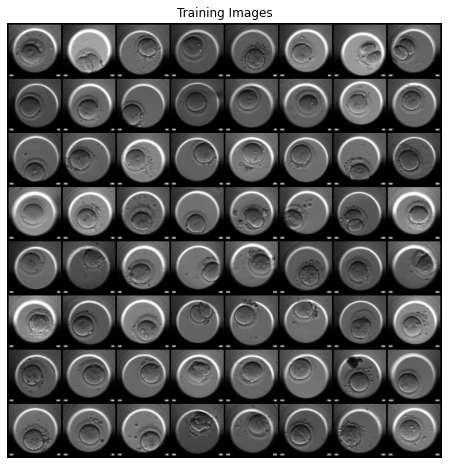

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], 
                                         padding=2, 
                                         normalize=True).cpu(),(1,2,0)));

In [7]:
# custom weights initialization called on Generator and Critic
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator For Generating Fake Images From Latent Vector

In [8]:
class Generator(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        # Filters [1024, 512, 256]
        self.main = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(100, 1024, 4, 1, 0),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(True),
            
            # State (1024x4x4)
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # State (256x16x16)
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # State (128x32x32)
            nn.ConvTranspose2d(128, channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [9]:
# Create the generator
gen = Generator(1).to(device)
gen.apply(weights_init);

### Critic For Classifying Fake And Real Images

In [10]:
class Critic(torch.nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.main = nn.Sequential(

            nn.Conv2d(channels, 128, 4, 2, 1),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x32x32)
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State (256x16x16)
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(1024, 1, 4, 1, 0))

    def forward(self, x):
        return self.main(x)

In [11]:
# Create the critic
critic = Critic(1).to(device)
critic.apply(weights_init);

## Optimizer

In [12]:
# Setup Adam optimizers for both G and C
crit_opt = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))

### Defining Wasserstein Loss For Calculating EDM Approximation

In [13]:
def get_gradient(crit, real, fake, epsilon):

    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [14]:
def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = (torch.mean(gradient_norm) - 1) ** 2
    return penalty

In [15]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

In [16]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + lambda_term * gp
    return crit_loss

## Training Step

In [17]:
generator_losses = []
critic_losses = []
img_list = []

for epoch in range(epochs):
    for param in critic.parameters():
        param.requires_grad = True

    mean_crit_loss = 0 
    for j in range(critic_iter):
        crit_opt.zero_grad()

        real_images = get_batch(dataloader).__next__().to(device)
        bs = real_images.size(0)
        z = torch.randn(bs, nz, 1, 1, device=device)
        fake_images = gen(z)

        crit_real_pred = critic(real_images)
        crit_fake_pred = critic(fake_images.detach())

        epsilon = torch.rand(bs, 1, 1, 1, device=device, requires_grad=True)
        gradient = get_gradient(critic, real_images, fake_images.detach(), epsilon)
        gp = gradient_penalty(gradient)

        crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, lambda_term)
        mean_crit_loss = crit_loss.item() / critic_iter
        crit_loss.backward(retain_graph=True)
        crit_opt.step()

    critic_losses.append(mean_crit_loss)

    for param in critic.parameters():
        param.requires_grad = False

    gen_opt.zero_grad()
    z = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = gen(z)
    crit_fake_pred = critic(fake_images)

    gen_loss = get_gen_loss(crit_fake_pred)
    gen_loss.backward()
    gen_opt.step()

    generator_losses.append(gen_loss.item())

    print('[%d/%d] Critic Loss: %.4f Gen Loss: %.4f' 
          % (epoch, epochs, critic_losses[-1], generator_losses[-1]))

    if (epoch % 5 == 0) or (epoch == epochs-1):
        with torch.no_grad():
              fake = gen(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


[0/10000] Critic Loss: 80.2911 Gen Loss: 0.0942
[1/10000] Critic Loss: 24.2046 Gen Loss: -2.0063
[2/10000] Critic Loss: 6.3121 Gen Loss: -2.9020
[3/10000] Critic Loss: 2.5717 Gen Loss: -3.4541
[4/10000] Critic Loss: 0.0509 Gen Loss: -3.9979
[5/10000] Critic Loss: -0.4282 Gen Loss: -4.0793
[6/10000] Critic Loss: -0.9323 Gen Loss: -3.8359
[7/10000] Critic Loss: -1.4460 Gen Loss: -3.2389
[8/10000] Critic Loss: -1.8879 Gen Loss: -2.5641
[9/10000] Critic Loss: -1.9855 Gen Loss: -1.8670
[10/10000] Critic Loss: -2.1693 Gen Loss: -1.1593
[11/10000] Critic Loss: -2.3251 Gen Loss: -0.2104
[12/10000] Critic Loss: -2.2143 Gen Loss: 0.3067
[13/10000] Critic Loss: -2.4620 Gen Loss: 1.0152
[14/10000] Critic Loss: -2.4458 Gen Loss: 1.4006
[15/10000] Critic Loss: -2.5160 Gen Loss: 1.5073
[16/10000] Critic Loss: -2.5718 Gen Loss: 1.8149
[17/10000] Critic Loss: -2.4494 Gen Loss: 1.7201
[18/10000] Critic Loss: -2.4298 Gen Loss: 1.4819
[19/10000] Critic Loss: -2.4240 Gen Loss: 1.5775
[20/10000] Critic Loss

[165/10000] Critic Loss: -0.9543 Gen Loss: 14.3436
[166/10000] Critic Loss: -0.8227 Gen Loss: 14.7943
[167/10000] Critic Loss: -0.9240 Gen Loss: 14.8694
[168/10000] Critic Loss: -0.8296 Gen Loss: 14.3001
[169/10000] Critic Loss: -0.9307 Gen Loss: 14.4768
[170/10000] Critic Loss: -0.8151 Gen Loss: 14.4642
[171/10000] Critic Loss: -0.9298 Gen Loss: 14.4754
[172/10000] Critic Loss: -0.9007 Gen Loss: 14.4718
[173/10000] Critic Loss: -0.9430 Gen Loss: 15.2392
[174/10000] Critic Loss: -0.8991 Gen Loss: 15.7366
[175/10000] Critic Loss: -0.9410 Gen Loss: 15.9737
[176/10000] Critic Loss: -1.0098 Gen Loss: 16.1902
[177/10000] Critic Loss: -0.9210 Gen Loss: 16.4806
[178/10000] Critic Loss: -0.8494 Gen Loss: 16.2100
[179/10000] Critic Loss: -0.8651 Gen Loss: 16.0494
[180/10000] Critic Loss: -0.8539 Gen Loss: 16.4802
[181/10000] Critic Loss: -0.9496 Gen Loss: 16.4701
[182/10000] Critic Loss: -0.8280 Gen Loss: 16.5089
[183/10000] Critic Loss: -0.9386 Gen Loss: 16.0660
[184/10000] Critic Loss: -0.914

[326/10000] Critic Loss: -0.9032 Gen Loss: 12.3026
[327/10000] Critic Loss: -0.9542 Gen Loss: 12.4532
[328/10000] Critic Loss: -0.8614 Gen Loss: 11.7327
[329/10000] Critic Loss: -0.9882 Gen Loss: 11.5063
[330/10000] Critic Loss: -0.8724 Gen Loss: 11.0169
[331/10000] Critic Loss: -0.9439 Gen Loss: 11.0959
[332/10000] Critic Loss: -0.8955 Gen Loss: 12.3188
[333/10000] Critic Loss: -0.9680 Gen Loss: 12.8222
[334/10000] Critic Loss: -1.1154 Gen Loss: 12.5682
[335/10000] Critic Loss: -1.0058 Gen Loss: 12.3468
[336/10000] Critic Loss: -0.8999 Gen Loss: 12.0087
[337/10000] Critic Loss: -1.0788 Gen Loss: 12.4457
[338/10000] Critic Loss: -0.8355 Gen Loss: 11.9057
[339/10000] Critic Loss: -0.9458 Gen Loss: 11.0962
[340/10000] Critic Loss: -1.0789 Gen Loss: 11.9824
[341/10000] Critic Loss: -1.0307 Gen Loss: 11.0059
[342/10000] Critic Loss: -1.1482 Gen Loss: 11.8649
[343/10000] Critic Loss: -0.9778 Gen Loss: 12.2116
[344/10000] Critic Loss: -0.8969 Gen Loss: 10.8075
[345/10000] Critic Loss: -0.924

[487/10000] Critic Loss: -0.9686 Gen Loss: 23.5283
[488/10000] Critic Loss: -1.4592 Gen Loss: 24.6828
[489/10000] Critic Loss: -1.0420 Gen Loss: 25.3426
[490/10000] Critic Loss: -1.2259 Gen Loss: 25.5790
[491/10000] Critic Loss: -0.8582 Gen Loss: 24.4557
[492/10000] Critic Loss: -0.7052 Gen Loss: 23.8853
[493/10000] Critic Loss: -1.0259 Gen Loss: 24.3565
[494/10000] Critic Loss: -1.2324 Gen Loss: 23.8476
[495/10000] Critic Loss: -0.8641 Gen Loss: 26.6352
[496/10000] Critic Loss: -1.0187 Gen Loss: 24.7674
[497/10000] Critic Loss: -1.0285 Gen Loss: 24.4459
[498/10000] Critic Loss: -0.9497 Gen Loss: 25.4089
[499/10000] Critic Loss: -1.4879 Gen Loss: 24.4736
[500/10000] Critic Loss: -1.3594 Gen Loss: 23.6609
[501/10000] Critic Loss: -1.1267 Gen Loss: 22.7270
[502/10000] Critic Loss: -1.3006 Gen Loss: 22.8024
[503/10000] Critic Loss: -1.1440 Gen Loss: 22.3809
[504/10000] Critic Loss: -1.1253 Gen Loss: 23.6172
[505/10000] Critic Loss: -1.0778 Gen Loss: 22.7077
[506/10000] Critic Loss: -0.908

[648/10000] Critic Loss: -1.3180 Gen Loss: 33.3419
[649/10000] Critic Loss: -1.2434 Gen Loss: 34.3128
[650/10000] Critic Loss: -1.3586 Gen Loss: 35.7206
[651/10000] Critic Loss: -0.9471 Gen Loss: 34.8872
[652/10000] Critic Loss: -1.0486 Gen Loss: 36.0561
[653/10000] Critic Loss: -1.3173 Gen Loss: 36.5002
[654/10000] Critic Loss: -1.3486 Gen Loss: 35.0234
[655/10000] Critic Loss: -1.4082 Gen Loss: 33.9153
[656/10000] Critic Loss: -1.2900 Gen Loss: 34.3863
[657/10000] Critic Loss: -1.2982 Gen Loss: 35.1239
[658/10000] Critic Loss: -1.0448 Gen Loss: 35.3321
[659/10000] Critic Loss: -1.4243 Gen Loss: 35.7830
[660/10000] Critic Loss: -1.2005 Gen Loss: 35.4799
[661/10000] Critic Loss: -1.2550 Gen Loss: 34.6146
[662/10000] Critic Loss: -0.9811 Gen Loss: 35.3300
[663/10000] Critic Loss: -1.2828 Gen Loss: 34.9625
[664/10000] Critic Loss: -1.0127 Gen Loss: 34.9224
[665/10000] Critic Loss: -1.2064 Gen Loss: 34.1086
[666/10000] Critic Loss: -1.8064 Gen Loss: 35.9974
[667/10000] Critic Loss: -0.861

[809/10000] Critic Loss: -1.4900 Gen Loss: 46.5476
[810/10000] Critic Loss: -1.5580 Gen Loss: 47.8972
[811/10000] Critic Loss: -2.4987 Gen Loss: 49.9021
[812/10000] Critic Loss: -1.4071 Gen Loss: 50.5415
[813/10000] Critic Loss: -1.1219 Gen Loss: 48.9488
[814/10000] Critic Loss: -1.3477 Gen Loss: 47.9731
[815/10000] Critic Loss: -1.5071 Gen Loss: 49.1547
[816/10000] Critic Loss: -1.1844 Gen Loss: 50.7494
[817/10000] Critic Loss: -1.0128 Gen Loss: 50.7745
[818/10000] Critic Loss: -1.3421 Gen Loss: 50.7871
[819/10000] Critic Loss: -0.9723 Gen Loss: 50.1747
[820/10000] Critic Loss: -0.8394 Gen Loss: 50.4457
[821/10000] Critic Loss: -1.1264 Gen Loss: 50.8338
[822/10000] Critic Loss: -1.5350 Gen Loss: 49.2045
[823/10000] Critic Loss: -1.1566 Gen Loss: 50.8676
[824/10000] Critic Loss: -1.3259 Gen Loss: 50.8937
[825/10000] Critic Loss: -1.4278 Gen Loss: 49.6564
[826/10000] Critic Loss: -1.3685 Gen Loss: 49.0702
[827/10000] Critic Loss: -0.8633 Gen Loss: 49.6530
[828/10000] Critic Loss: -1.423

[970/10000] Critic Loss: -1.2246 Gen Loss: 61.7657
[971/10000] Critic Loss: -1.4269 Gen Loss: 62.8201
[972/10000] Critic Loss: -1.1518 Gen Loss: 62.3178
[973/10000] Critic Loss: -1.3334 Gen Loss: 61.7423
[974/10000] Critic Loss: -1.2572 Gen Loss: 62.1501
[975/10000] Critic Loss: -1.2787 Gen Loss: 62.6291
[976/10000] Critic Loss: -1.6747 Gen Loss: 60.1283
[977/10000] Critic Loss: -1.5155 Gen Loss: 64.6569
[978/10000] Critic Loss: -0.8867 Gen Loss: 63.8220
[979/10000] Critic Loss: -1.5597 Gen Loss: 61.7601
[980/10000] Critic Loss: -1.1154 Gen Loss: 61.6189
[981/10000] Critic Loss: -1.5471 Gen Loss: 61.4164
[982/10000] Critic Loss: -0.7064 Gen Loss: 62.0074
[983/10000] Critic Loss: -1.5982 Gen Loss: 59.7058
[984/10000] Critic Loss: -1.5395 Gen Loss: 60.9763
[985/10000] Critic Loss: -1.2120 Gen Loss: 61.5042
[986/10000] Critic Loss: -1.4192 Gen Loss: 61.8629
[987/10000] Critic Loss: -1.5842 Gen Loss: 61.6440
[988/10000] Critic Loss: -1.1372 Gen Loss: 61.2965
[989/10000] Critic Loss: -1.381

[1129/10000] Critic Loss: -1.1372 Gen Loss: 76.1713
[1130/10000] Critic Loss: -1.7975 Gen Loss: 78.0041
[1131/10000] Critic Loss: -1.4292 Gen Loss: 77.1063
[1132/10000] Critic Loss: -1.5582 Gen Loss: 77.7783
[1133/10000] Critic Loss: -1.4033 Gen Loss: 77.7968
[1134/10000] Critic Loss: -1.9048 Gen Loss: 77.5486
[1135/10000] Critic Loss: -2.8289 Gen Loss: 78.8585
[1136/10000] Critic Loss: -1.1273 Gen Loss: 81.6849
[1137/10000] Critic Loss: -2.0407 Gen Loss: 79.3950
[1138/10000] Critic Loss: -1.2775 Gen Loss: 78.0403
[1139/10000] Critic Loss: -1.1729 Gen Loss: 79.5467
[1140/10000] Critic Loss: -2.4602 Gen Loss: 78.5775
[1141/10000] Critic Loss: -1.4901 Gen Loss: 79.5604
[1142/10000] Critic Loss: -1.3490 Gen Loss: 80.2089
[1143/10000] Critic Loss: -0.8447 Gen Loss: 80.7740
[1144/10000] Critic Loss: -1.5615 Gen Loss: 77.8600
[1145/10000] Critic Loss: -1.2422 Gen Loss: 80.6597
[1146/10000] Critic Loss: -1.7802 Gen Loss: 79.5998
[1147/10000] Critic Loss: -1.9529 Gen Loss: 80.1850
[1148/10000]

[1287/10000] Critic Loss: -0.9981 Gen Loss: 93.6431
[1288/10000] Critic Loss: -1.2593 Gen Loss: 93.0195
[1289/10000] Critic Loss: -1.3961 Gen Loss: 93.6238
[1290/10000] Critic Loss: -1.7962 Gen Loss: 93.2738
[1291/10000] Critic Loss: -2.7867 Gen Loss: 93.7960
[1292/10000] Critic Loss: -1.6083 Gen Loss: 94.2388
[1293/10000] Critic Loss: -1.1834 Gen Loss: 95.5646
[1294/10000] Critic Loss: -2.4090 Gen Loss: 93.8921
[1295/10000] Critic Loss: -2.3022 Gen Loss: 95.4961
[1296/10000] Critic Loss: -1.5103 Gen Loss: 95.3526
[1297/10000] Critic Loss: -0.6791 Gen Loss: 94.6081
[1298/10000] Critic Loss: -2.6392 Gen Loss: 94.5507
[1299/10000] Critic Loss: -2.3003 Gen Loss: 94.8701
[1300/10000] Critic Loss: -1.0076 Gen Loss: 96.8044
[1301/10000] Critic Loss: -1.8151 Gen Loss: 93.1110
[1302/10000] Critic Loss: -2.5282 Gen Loss: 96.9674
[1303/10000] Critic Loss: -1.3381 Gen Loss: 97.3917
[1304/10000] Critic Loss: -1.1824 Gen Loss: 98.4396
[1305/10000] Critic Loss: -2.3991 Gen Loss: 98.9614
[1306/10000]

[1443/10000] Critic Loss: -1.8863 Gen Loss: 108.4528
[1444/10000] Critic Loss: -1.3355 Gen Loss: 110.9715
[1445/10000] Critic Loss: -1.8225 Gen Loss: 110.2348
[1446/10000] Critic Loss: -2.1967 Gen Loss: 110.8067
[1447/10000] Critic Loss: -1.8893 Gen Loss: 112.5094
[1448/10000] Critic Loss: -1.4348 Gen Loss: 112.6258
[1449/10000] Critic Loss: -3.1732 Gen Loss: 109.2266
[1450/10000] Critic Loss: -1.8994 Gen Loss: 112.7273
[1451/10000] Critic Loss: -2.0106 Gen Loss: 110.6831
[1452/10000] Critic Loss: -0.7215 Gen Loss: 113.9138
[1453/10000] Critic Loss: -1.8875 Gen Loss: 111.6399
[1454/10000] Critic Loss: -2.7363 Gen Loss: 111.3716
[1455/10000] Critic Loss: -1.7437 Gen Loss: 112.6314
[1456/10000] Critic Loss: -2.2484 Gen Loss: 110.4407
[1457/10000] Critic Loss: -1.0775 Gen Loss: 115.0191
[1458/10000] Critic Loss: -1.5444 Gen Loss: 109.4239
[1459/10000] Critic Loss: -1.1954 Gen Loss: 113.1389
[1460/10000] Critic Loss: -1.5623 Gen Loss: 113.0939
[1461/10000] Critic Loss: -2.5754 Gen Loss: 11

[1598/10000] Critic Loss: -2.0933 Gen Loss: 125.2860
[1599/10000] Critic Loss: -2.1573 Gen Loss: 127.6390
[1600/10000] Critic Loss: -1.6210 Gen Loss: 129.8518
[1601/10000] Critic Loss: -1.6651 Gen Loss: 129.4714
[1602/10000] Critic Loss: -1.2688 Gen Loss: 129.3333
[1603/10000] Critic Loss: -3.0694 Gen Loss: 128.6543
[1604/10000] Critic Loss: -1.1944 Gen Loss: 129.6073
[1605/10000] Critic Loss: -1.0665 Gen Loss: 127.2675
[1606/10000] Critic Loss: -1.6287 Gen Loss: 128.3149
[1607/10000] Critic Loss: -1.6315 Gen Loss: 128.1245
[1608/10000] Critic Loss: -1.6884 Gen Loss: 129.8954
[1609/10000] Critic Loss: -2.0440 Gen Loss: 130.6661
[1610/10000] Critic Loss: -2.1951 Gen Loss: 133.8049
[1611/10000] Critic Loss: -1.2811 Gen Loss: 131.4424
[1612/10000] Critic Loss: -1.5329 Gen Loss: 128.1553
[1613/10000] Critic Loss: -1.5545 Gen Loss: 129.9666
[1614/10000] Critic Loss: -1.8884 Gen Loss: 130.3178
[1615/10000] Critic Loss: -1.4989 Gen Loss: 130.8937
[1616/10000] Critic Loss: -1.0424 Gen Loss: 13

[1753/10000] Critic Loss: -0.9596 Gen Loss: 145.1531
[1754/10000] Critic Loss: -0.9236 Gen Loss: 145.0501
[1755/10000] Critic Loss: -2.9426 Gen Loss: 145.3994
[1756/10000] Critic Loss: -1.7592 Gen Loss: 145.1875
[1757/10000] Critic Loss: -1.2453 Gen Loss: 147.3920
[1758/10000] Critic Loss: -1.0548 Gen Loss: 142.9342
[1759/10000] Critic Loss: -0.8854 Gen Loss: 145.4322
[1760/10000] Critic Loss: -1.2215 Gen Loss: 144.8100
[1761/10000] Critic Loss: -2.3094 Gen Loss: 145.4697
[1762/10000] Critic Loss: -1.7419 Gen Loss: 145.7765
[1763/10000] Critic Loss: -1.6568 Gen Loss: 146.1298
[1764/10000] Critic Loss: -1.7436 Gen Loss: 145.1673
[1765/10000] Critic Loss: -1.9465 Gen Loss: 146.7309
[1766/10000] Critic Loss: -1.7028 Gen Loss: 145.4414
[1767/10000] Critic Loss: -2.1926 Gen Loss: 145.6872
[1768/10000] Critic Loss: -1.8367 Gen Loss: 145.6329
[1769/10000] Critic Loss: -1.8856 Gen Loss: 148.2042
[1770/10000] Critic Loss: -2.8051 Gen Loss: 148.7612
[1771/10000] Critic Loss: -1.7808 Gen Loss: 15

[1908/10000] Critic Loss: -2.1675 Gen Loss: 162.6482
[1909/10000] Critic Loss: -2.4356 Gen Loss: 162.3866
[1910/10000] Critic Loss: -2.5777 Gen Loss: 162.4789
[1911/10000] Critic Loss: -1.8582 Gen Loss: 167.5367
[1912/10000] Critic Loss: -2.7760 Gen Loss: 161.5751
[1913/10000] Critic Loss: -3.1255 Gen Loss: 165.6451
[1914/10000] Critic Loss: -0.5377 Gen Loss: 165.3728
[1915/10000] Critic Loss: -1.1759 Gen Loss: 166.2513
[1916/10000] Critic Loss: -1.1870 Gen Loss: 165.0256
[1917/10000] Critic Loss: -3.0432 Gen Loss: 162.8390
[1918/10000] Critic Loss: -1.7210 Gen Loss: 164.7654
[1919/10000] Critic Loss: -2.1176 Gen Loss: 163.1800
[1920/10000] Critic Loss: -1.7776 Gen Loss: 164.7516
[1921/10000] Critic Loss: -2.2686 Gen Loss: 161.9532
[1922/10000] Critic Loss: -0.9809 Gen Loss: 166.1850
[1923/10000] Critic Loss: -1.9131 Gen Loss: 161.7097
[1924/10000] Critic Loss: -1.3554 Gen Loss: 162.9049
[1925/10000] Critic Loss: -2.1655 Gen Loss: 162.3097
[1926/10000] Critic Loss: -0.9669 Gen Loss: 16

[2063/10000] Critic Loss: -3.0996 Gen Loss: 179.2349
[2064/10000] Critic Loss: -1.6032 Gen Loss: 180.8984
[2065/10000] Critic Loss: -2.2634 Gen Loss: 180.5452
[2066/10000] Critic Loss: -2.6042 Gen Loss: 181.1496
[2067/10000] Critic Loss: -1.9400 Gen Loss: 180.7716
[2068/10000] Critic Loss: -1.5181 Gen Loss: 181.4345
[2069/10000] Critic Loss: -1.1153 Gen Loss: 182.6769
[2070/10000] Critic Loss: -1.4870 Gen Loss: 181.1699
[2071/10000] Critic Loss: -1.6048 Gen Loss: 179.8363
[2072/10000] Critic Loss: -2.6427 Gen Loss: 183.1068
[2073/10000] Critic Loss: -2.4367 Gen Loss: 183.4080
[2074/10000] Critic Loss: -2.3527 Gen Loss: 181.1418
[2075/10000] Critic Loss: -1.9108 Gen Loss: 180.3983
[2076/10000] Critic Loss: -1.6895 Gen Loss: 182.2329
[2077/10000] Critic Loss: -0.8833 Gen Loss: 179.2873
[2078/10000] Critic Loss: -1.5500 Gen Loss: 178.7401
[2079/10000] Critic Loss: -1.4881 Gen Loss: 180.1047
[2080/10000] Critic Loss: -2.2685 Gen Loss: 179.1860
[2081/10000] Critic Loss: -2.1128 Gen Loss: 18

[2218/10000] Critic Loss: -1.3908 Gen Loss: 200.7574
[2219/10000] Critic Loss: -1.8984 Gen Loss: 196.9056
[2220/10000] Critic Loss: -1.8398 Gen Loss: 198.8166
[2221/10000] Critic Loss: -3.0291 Gen Loss: 199.7536
[2222/10000] Critic Loss: -0.9632 Gen Loss: 200.6383
[2223/10000] Critic Loss: -2.1298 Gen Loss: 198.9164
[2224/10000] Critic Loss: -3.2439 Gen Loss: 197.9911
[2225/10000] Critic Loss: 1.1648 Gen Loss: 200.3645
[2226/10000] Critic Loss: -1.3749 Gen Loss: 199.0170
[2227/10000] Critic Loss: -2.0706 Gen Loss: 198.4792
[2228/10000] Critic Loss: -1.8788 Gen Loss: 199.7300
[2229/10000] Critic Loss: -2.9251 Gen Loss: 197.6772
[2230/10000] Critic Loss: -1.0149 Gen Loss: 200.5920
[2231/10000] Critic Loss: -1.7703 Gen Loss: 206.0704
[2232/10000] Critic Loss: -2.2498 Gen Loss: 199.7597
[2233/10000] Critic Loss: -3.0600 Gen Loss: 198.7288
[2234/10000] Critic Loss: -2.2091 Gen Loss: 200.8602
[2235/10000] Critic Loss: -1.7585 Gen Loss: 199.6553
[2236/10000] Critic Loss: -1.8630 Gen Loss: 200

[2373/10000] Critic Loss: -2.3616 Gen Loss: 209.4248
[2374/10000] Critic Loss: -1.5932 Gen Loss: 209.4976
[2375/10000] Critic Loss: -2.0104 Gen Loss: 211.0536
[2376/10000] Critic Loss: -2.2524 Gen Loss: 209.9223
[2377/10000] Critic Loss: -0.3223 Gen Loss: 210.5766
[2378/10000] Critic Loss: -4.1676 Gen Loss: 209.5632
[2379/10000] Critic Loss: -2.5706 Gen Loss: 212.0789
[2380/10000] Critic Loss: -0.8183 Gen Loss: 212.4483
[2381/10000] Critic Loss: -2.3623 Gen Loss: 212.4899
[2382/10000] Critic Loss: -1.7850 Gen Loss: 211.8672
[2383/10000] Critic Loss: -1.2841 Gen Loss: 210.1241
[2384/10000] Critic Loss: -1.0303 Gen Loss: 211.7226
[2385/10000] Critic Loss: -1.3163 Gen Loss: 208.5919
[2386/10000] Critic Loss: -1.9346 Gen Loss: 212.4246
[2387/10000] Critic Loss: -1.2990 Gen Loss: 212.3381
[2388/10000] Critic Loss: -1.3413 Gen Loss: 211.9055
[2389/10000] Critic Loss: -1.9923 Gen Loss: 212.5871
[2390/10000] Critic Loss: -1.7488 Gen Loss: 214.0741
[2391/10000] Critic Loss: -1.4540 Gen Loss: 21

[2528/10000] Critic Loss: -2.7117 Gen Loss: 226.5275
[2529/10000] Critic Loss: -0.6651 Gen Loss: 227.9025
[2530/10000] Critic Loss: -1.7339 Gen Loss: 226.7050
[2531/10000] Critic Loss: -2.0856 Gen Loss: 226.7656
[2532/10000] Critic Loss: -2.0693 Gen Loss: 230.2998
[2533/10000] Critic Loss: -1.2135 Gen Loss: 227.6576
[2534/10000] Critic Loss: -3.0188 Gen Loss: 226.8133
[2535/10000] Critic Loss: -2.1358 Gen Loss: 227.4458
[2536/10000] Critic Loss: -1.0051 Gen Loss: 228.2387
[2537/10000] Critic Loss: -2.4378 Gen Loss: 227.1082
[2538/10000] Critic Loss: -1.2543 Gen Loss: 230.8674
[2539/10000] Critic Loss: -1.7792 Gen Loss: 229.6296
[2540/10000] Critic Loss: -1.9347 Gen Loss: 230.6609
[2541/10000] Critic Loss: -1.9963 Gen Loss: 228.5171
[2542/10000] Critic Loss: -1.4171 Gen Loss: 229.9246
[2543/10000] Critic Loss: -1.8508 Gen Loss: 230.0703
[2544/10000] Critic Loss: -1.3923 Gen Loss: 229.8982
[2545/10000] Critic Loss: -2.9737 Gen Loss: 228.8951
[2546/10000] Critic Loss: -2.2625 Gen Loss: 23

[2683/10000] Critic Loss: -2.2394 Gen Loss: 249.9989
[2684/10000] Critic Loss: -0.9788 Gen Loss: 246.3093
[2685/10000] Critic Loss: -0.2836 Gen Loss: 251.5955
[2686/10000] Critic Loss: -1.5081 Gen Loss: 247.9622
[2687/10000] Critic Loss: -1.5248 Gen Loss: 247.9503
[2688/10000] Critic Loss: -2.1859 Gen Loss: 249.4258
[2689/10000] Critic Loss: -0.8631 Gen Loss: 250.0374
[2690/10000] Critic Loss: -2.2110 Gen Loss: 247.1306
[2691/10000] Critic Loss: -1.0872 Gen Loss: 249.1720
[2692/10000] Critic Loss: -1.3654 Gen Loss: 249.6401
[2693/10000] Critic Loss: -1.7194 Gen Loss: 248.7536
[2694/10000] Critic Loss: -2.4046 Gen Loss: 248.0963
[2695/10000] Critic Loss: -2.8146 Gen Loss: 250.2243
[2696/10000] Critic Loss: -1.9127 Gen Loss: 248.0768
[2697/10000] Critic Loss: 0.3239 Gen Loss: 250.7756
[2698/10000] Critic Loss: -1.7102 Gen Loss: 247.6651
[2699/10000] Critic Loss: -2.5755 Gen Loss: 249.5916
[2700/10000] Critic Loss: -1.2101 Gen Loss: 249.7560
[2701/10000] Critic Loss: -2.3313 Gen Loss: 247

[2838/10000] Critic Loss: -1.3339 Gen Loss: 255.8938
[2839/10000] Critic Loss: -2.4171 Gen Loss: 256.9155
[2840/10000] Critic Loss: -1.7096 Gen Loss: 255.1943
[2841/10000] Critic Loss: -2.7508 Gen Loss: 256.6155
[2842/10000] Critic Loss: -2.5929 Gen Loss: 257.1129
[2843/10000] Critic Loss: -3.2184 Gen Loss: 254.4580
[2844/10000] Critic Loss: -2.8816 Gen Loss: 256.2439
[2845/10000] Critic Loss: -1.3599 Gen Loss: 258.5725
[2846/10000] Critic Loss: -1.5583 Gen Loss: 258.4957
[2847/10000] Critic Loss: -1.7827 Gen Loss: 257.2548
[2848/10000] Critic Loss: -2.1023 Gen Loss: 258.4377
[2849/10000] Critic Loss: -2.5742 Gen Loss: 258.4225
[2850/10000] Critic Loss: -1.8505 Gen Loss: 258.5201
[2851/10000] Critic Loss: -1.4886 Gen Loss: 259.9305
[2852/10000] Critic Loss: -2.4873 Gen Loss: 258.5498
[2853/10000] Critic Loss: -1.3110 Gen Loss: 259.2562
[2854/10000] Critic Loss: -1.2849 Gen Loss: 256.9293
[2855/10000] Critic Loss: -2.2810 Gen Loss: 259.6156
[2856/10000] Critic Loss: -1.2502 Gen Loss: 26

[2993/10000] Critic Loss: -3.3718 Gen Loss: 271.8578
[2994/10000] Critic Loss: -2.1010 Gen Loss: 268.6844
[2995/10000] Critic Loss: -2.1431 Gen Loss: 270.2140
[2996/10000] Critic Loss: -1.6689 Gen Loss: 271.5631
[2997/10000] Critic Loss: -1.3147 Gen Loss: 268.4698
[2998/10000] Critic Loss: -1.1626 Gen Loss: 270.7489
[2999/10000] Critic Loss: -1.3355 Gen Loss: 269.4860
[3000/10000] Critic Loss: -2.0056 Gen Loss: 269.5387
[3001/10000] Critic Loss: -4.2694 Gen Loss: 271.2289
[3002/10000] Critic Loss: -4.4195 Gen Loss: 270.7628
[3003/10000] Critic Loss: -1.3442 Gen Loss: 272.6382
[3004/10000] Critic Loss: -1.5318 Gen Loss: 272.5292
[3005/10000] Critic Loss: -1.3131 Gen Loss: 271.5329
[3006/10000] Critic Loss: -3.1083 Gen Loss: 273.6029
[3007/10000] Critic Loss: -1.2712 Gen Loss: 272.8921
[3008/10000] Critic Loss: -1.5668 Gen Loss: 272.2413
[3009/10000] Critic Loss: -0.9862 Gen Loss: 273.3496
[3010/10000] Critic Loss: -1.9271 Gen Loss: 272.2237
[3011/10000] Critic Loss: -0.9115 Gen Loss: 27

[3148/10000] Critic Loss: -2.2390 Gen Loss: 292.5636
[3149/10000] Critic Loss: -1.7304 Gen Loss: 292.2038
[3150/10000] Critic Loss: -1.3527 Gen Loss: 291.7493
[3151/10000] Critic Loss: -1.7458 Gen Loss: 291.7073
[3152/10000] Critic Loss: -1.6112 Gen Loss: 295.1539
[3153/10000] Critic Loss: -1.5158 Gen Loss: 290.9550
[3154/10000] Critic Loss: -2.7378 Gen Loss: 291.4561
[3155/10000] Critic Loss: -0.8850 Gen Loss: 293.9661
[3156/10000] Critic Loss: -2.6035 Gen Loss: 288.8122
[3157/10000] Critic Loss: -2.1699 Gen Loss: 292.8901
[3158/10000] Critic Loss: -2.5352 Gen Loss: 292.4888
[3159/10000] Critic Loss: -1.6861 Gen Loss: 293.0603
[3160/10000] Critic Loss: -2.0296 Gen Loss: 291.5886
[3161/10000] Critic Loss: -1.9471 Gen Loss: 293.9670
[3162/10000] Critic Loss: -1.0323 Gen Loss: 295.3123
[3163/10000] Critic Loss: -2.0314 Gen Loss: 293.6147
[3164/10000] Critic Loss: -1.5604 Gen Loss: 291.9568
[3165/10000] Critic Loss: -0.6324 Gen Loss: 291.9539
[3166/10000] Critic Loss: -3.3091 Gen Loss: 29

[3303/10000] Critic Loss: -2.2590 Gen Loss: 301.5477
[3304/10000] Critic Loss: -2.0715 Gen Loss: 300.3792
[3305/10000] Critic Loss: -1.9596 Gen Loss: 301.2450
[3306/10000] Critic Loss: -2.3125 Gen Loss: 303.5838
[3307/10000] Critic Loss: -3.1876 Gen Loss: 302.4968
[3308/10000] Critic Loss: -1.6585 Gen Loss: 304.8405
[3309/10000] Critic Loss: -1.4718 Gen Loss: 303.4871
[3310/10000] Critic Loss: -1.5057 Gen Loss: 301.5097
[3311/10000] Critic Loss: -1.9818 Gen Loss: 300.8562
[3312/10000] Critic Loss: -1.1778 Gen Loss: 304.5569
[3313/10000] Critic Loss: -1.7832 Gen Loss: 302.1709
[3314/10000] Critic Loss: -2.2776 Gen Loss: 301.7501
[3315/10000] Critic Loss: -1.7452 Gen Loss: 302.9257
[3316/10000] Critic Loss: -1.2336 Gen Loss: 304.0732
[3317/10000] Critic Loss: -1.2989 Gen Loss: 303.5424
[3318/10000] Critic Loss: -1.9635 Gen Loss: 303.1677
[3319/10000] Critic Loss: -1.9343 Gen Loss: 301.3109
[3320/10000] Critic Loss: -3.9767 Gen Loss: 304.3897
[3321/10000] Critic Loss: -2.0658 Gen Loss: 30

[3458/10000] Critic Loss: -1.9289 Gen Loss: 318.7865
[3459/10000] Critic Loss: -2.1340 Gen Loss: 319.3980
[3460/10000] Critic Loss: -1.5638 Gen Loss: 319.6857
[3461/10000] Critic Loss: -1.7894 Gen Loss: 316.7405
[3462/10000] Critic Loss: -3.4246 Gen Loss: 318.0300
[3463/10000] Critic Loss: -1.2470 Gen Loss: 320.8607
[3464/10000] Critic Loss: -2.0759 Gen Loss: 321.3100
[3465/10000] Critic Loss: -1.4544 Gen Loss: 320.5556
[3466/10000] Critic Loss: -2.6122 Gen Loss: 321.1718
[3467/10000] Critic Loss: -2.9397 Gen Loss: 321.9283
[3468/10000] Critic Loss: -1.6064 Gen Loss: 317.4769
[3469/10000] Critic Loss: -1.1012 Gen Loss: 313.7905
[3470/10000] Critic Loss: -1.3957 Gen Loss: 317.4901
[3471/10000] Critic Loss: -1.4369 Gen Loss: 318.8378
[3472/10000] Critic Loss: -0.3336 Gen Loss: 320.5638
[3473/10000] Critic Loss: -1.5160 Gen Loss: 318.6864
[3474/10000] Critic Loss: -2.4372 Gen Loss: 317.8370
[3475/10000] Critic Loss: -0.8246 Gen Loss: 321.0846
[3476/10000] Critic Loss: -1.9417 Gen Loss: 32

[3613/10000] Critic Loss: -2.8206 Gen Loss: 332.9733
[3614/10000] Critic Loss: -3.1067 Gen Loss: 335.7022
[3615/10000] Critic Loss: -1.6009 Gen Loss: 333.1580
[3616/10000] Critic Loss: -3.9041 Gen Loss: 333.3781
[3617/10000] Critic Loss: -1.5076 Gen Loss: 338.5137
[3618/10000] Critic Loss: -1.5973 Gen Loss: 337.9919
[3619/10000] Critic Loss: -1.4882 Gen Loss: 336.0389
[3620/10000] Critic Loss: -2.4176 Gen Loss: 335.1869
[3621/10000] Critic Loss: -1.2942 Gen Loss: 335.4909
[3622/10000] Critic Loss: -1.2296 Gen Loss: 337.1288
[3623/10000] Critic Loss: -1.9842 Gen Loss: 340.0100
[3624/10000] Critic Loss: -3.1656 Gen Loss: 335.9962
[3625/10000] Critic Loss: -1.7210 Gen Loss: 335.4169
[3626/10000] Critic Loss: -2.0784 Gen Loss: 336.0773
[3627/10000] Critic Loss: -2.1088 Gen Loss: 338.0111
[3628/10000] Critic Loss: -2.0432 Gen Loss: 336.3913
[3629/10000] Critic Loss: -2.3300 Gen Loss: 336.2952
[3630/10000] Critic Loss: -2.1738 Gen Loss: 334.6636
[3631/10000] Critic Loss: -1.8506 Gen Loss: 33

[3768/10000] Critic Loss: -1.6301 Gen Loss: 354.3618
[3769/10000] Critic Loss: -1.7785 Gen Loss: 359.4209
[3770/10000] Critic Loss: -2.5664 Gen Loss: 356.5361
[3771/10000] Critic Loss: -2.7752 Gen Loss: 354.7027
[3772/10000] Critic Loss: -1.1697 Gen Loss: 358.7927
[3773/10000] Critic Loss: -3.6055 Gen Loss: 354.1064
[3774/10000] Critic Loss: -2.5021 Gen Loss: 357.9306
[3775/10000] Critic Loss: -2.3172 Gen Loss: 356.8372
[3776/10000] Critic Loss: -1.5659 Gen Loss: 355.7880
[3777/10000] Critic Loss: -1.9097 Gen Loss: 356.8180
[3778/10000] Critic Loss: -1.9327 Gen Loss: 357.8631
[3779/10000] Critic Loss: -2.4702 Gen Loss: 353.6616
[3780/10000] Critic Loss: -2.6145 Gen Loss: 357.2445
[3781/10000] Critic Loss: -1.7908 Gen Loss: 356.8729
[3782/10000] Critic Loss: -2.2741 Gen Loss: 357.8264
[3783/10000] Critic Loss: -3.8378 Gen Loss: 357.2888
[3784/10000] Critic Loss: -1.1839 Gen Loss: 358.6281
[3785/10000] Critic Loss: -1.4200 Gen Loss: 358.3340
[3786/10000] Critic Loss: -2.1408 Gen Loss: 35

[3923/10000] Critic Loss: -2.7963 Gen Loss: 369.7324
[3924/10000] Critic Loss: -0.6222 Gen Loss: 374.4952
[3925/10000] Critic Loss: -2.3921 Gen Loss: 369.8456
[3926/10000] Critic Loss: -3.8511 Gen Loss: 369.7049
[3927/10000] Critic Loss: -0.9444 Gen Loss: 371.4127
[3928/10000] Critic Loss: -2.5333 Gen Loss: 371.5577
[3929/10000] Critic Loss: -0.4918 Gen Loss: 373.5436
[3930/10000] Critic Loss: -1.8414 Gen Loss: 373.1507
[3931/10000] Critic Loss: -2.4791 Gen Loss: 371.9893
[3932/10000] Critic Loss: -2.0177 Gen Loss: 369.3012
[3933/10000] Critic Loss: -0.8710 Gen Loss: 368.1840
[3934/10000] Critic Loss: -1.0178 Gen Loss: 370.7342
[3935/10000] Critic Loss: -4.2712 Gen Loss: 371.2127
[3936/10000] Critic Loss: -3.1766 Gen Loss: 369.5298
[3937/10000] Critic Loss: -3.2967 Gen Loss: 369.1974
[3938/10000] Critic Loss: -2.3472 Gen Loss: 371.8380
[3939/10000] Critic Loss: -2.3102 Gen Loss: 372.2702
[3940/10000] Critic Loss: -3.3701 Gen Loss: 372.5092
[3941/10000] Critic Loss: -1.0585 Gen Loss: 37

[4078/10000] Critic Loss: -3.6964 Gen Loss: 386.8770
[4079/10000] Critic Loss: -2.6109 Gen Loss: 388.5486
[4080/10000] Critic Loss: -2.3071 Gen Loss: 384.8737
[4081/10000] Critic Loss: -2.7680 Gen Loss: 387.4812
[4082/10000] Critic Loss: -1.6869 Gen Loss: 387.4473
[4083/10000] Critic Loss: -2.7495 Gen Loss: 387.3407
[4084/10000] Critic Loss: -1.7165 Gen Loss: 387.6190
[4085/10000] Critic Loss: -2.5887 Gen Loss: 386.7268
[4086/10000] Critic Loss: -2.9173 Gen Loss: 388.0179
[4087/10000] Critic Loss: -2.0465 Gen Loss: 387.7369
[4088/10000] Critic Loss: -1.2391 Gen Loss: 391.6898
[4089/10000] Critic Loss: -2.6984 Gen Loss: 388.9237
[4090/10000] Critic Loss: -1.9746 Gen Loss: 388.2308
[4091/10000] Critic Loss: -1.3599 Gen Loss: 388.7271
[4092/10000] Critic Loss: -1.2380 Gen Loss: 385.5247
[4093/10000] Critic Loss: -2.2932 Gen Loss: 388.7547
[4094/10000] Critic Loss: -2.8793 Gen Loss: 390.2321
[4095/10000] Critic Loss: -2.0762 Gen Loss: 388.7684
[4096/10000] Critic Loss: -0.7086 Gen Loss: 38

[4233/10000] Critic Loss: -1.7262 Gen Loss: 400.6232
[4234/10000] Critic Loss: -2.6154 Gen Loss: 399.6530
[4235/10000] Critic Loss: -2.5778 Gen Loss: 400.8257
[4236/10000] Critic Loss: -2.2622 Gen Loss: 403.2546
[4237/10000] Critic Loss: -1.5264 Gen Loss: 402.4590
[4238/10000] Critic Loss: -3.0805 Gen Loss: 401.4561
[4239/10000] Critic Loss: -1.4699 Gen Loss: 403.9641
[4240/10000] Critic Loss: -3.2327 Gen Loss: 403.6956
[4241/10000] Critic Loss: -1.8642 Gen Loss: 405.0744
[4242/10000] Critic Loss: -3.3149 Gen Loss: 401.8225
[4243/10000] Critic Loss: -3.0508 Gen Loss: 404.0290
[4244/10000] Critic Loss: -1.5671 Gen Loss: 404.2734
[4245/10000] Critic Loss: -2.5144 Gen Loss: 405.3297
[4246/10000] Critic Loss: -2.2328 Gen Loss: 403.8606
[4247/10000] Critic Loss: -1.6392 Gen Loss: 405.2236
[4248/10000] Critic Loss: -1.4436 Gen Loss: 407.6827
[4249/10000] Critic Loss: -2.4207 Gen Loss: 403.3089
[4250/10000] Critic Loss: -1.3360 Gen Loss: 405.4518
[4251/10000] Critic Loss: -1.4335 Gen Loss: 40

[4388/10000] Critic Loss: -2.3384 Gen Loss: 418.1486
[4389/10000] Critic Loss: -1.6045 Gen Loss: 420.5411
[4390/10000] Critic Loss: -1.7881 Gen Loss: 420.0131
[4391/10000] Critic Loss: -2.2324 Gen Loss: 421.5403
[4392/10000] Critic Loss: -3.5913 Gen Loss: 421.1417
[4393/10000] Critic Loss: -1.0093 Gen Loss: 420.1891
[4394/10000] Critic Loss: -1.7601 Gen Loss: 417.5624
[4395/10000] Critic Loss: -1.3239 Gen Loss: 422.0954
[4396/10000] Critic Loss: -1.2751 Gen Loss: 421.6902
[4397/10000] Critic Loss: -1.2077 Gen Loss: 421.8993
[4398/10000] Critic Loss: -1.6075 Gen Loss: 423.5904
[4399/10000] Critic Loss: -2.7316 Gen Loss: 419.9235
[4400/10000] Critic Loss: -2.3030 Gen Loss: 423.2023
[4401/10000] Critic Loss: -4.0941 Gen Loss: 420.7512
[4402/10000] Critic Loss: -3.3583 Gen Loss: 423.0068
[4403/10000] Critic Loss: -1.4915 Gen Loss: 420.2005
[4404/10000] Critic Loss: -3.3203 Gen Loss: 423.6622
[4405/10000] Critic Loss: -4.4746 Gen Loss: 423.5013
[4406/10000] Critic Loss: -2.7582 Gen Loss: 42

[4543/10000] Critic Loss: -2.2575 Gen Loss: 440.8929
[4544/10000] Critic Loss: -3.4194 Gen Loss: 439.4345
[4545/10000] Critic Loss: -2.5170 Gen Loss: 437.6606
[4546/10000] Critic Loss: -3.0812 Gen Loss: 438.3661
[4547/10000] Critic Loss: -3.0239 Gen Loss: 440.1541
[4548/10000] Critic Loss: -1.3653 Gen Loss: 439.3543
[4549/10000] Critic Loss: -1.6313 Gen Loss: 440.7408
[4550/10000] Critic Loss: -2.0076 Gen Loss: 440.7213
[4551/10000] Critic Loss: -1.9037 Gen Loss: 441.8750
[4552/10000] Critic Loss: -3.1903 Gen Loss: 440.3887
[4553/10000] Critic Loss: -1.5821 Gen Loss: 440.4825
[4554/10000] Critic Loss: -2.6236 Gen Loss: 439.1438
[4555/10000] Critic Loss: -2.3734 Gen Loss: 438.2216
[4556/10000] Critic Loss: -2.3150 Gen Loss: 440.8386
[4557/10000] Critic Loss: -2.2666 Gen Loss: 439.2380
[4558/10000] Critic Loss: -1.2631 Gen Loss: 440.7582
[4559/10000] Critic Loss: -1.0489 Gen Loss: 439.8494
[4560/10000] Critic Loss: -1.2370 Gen Loss: 439.8904
[4561/10000] Critic Loss: -1.0094 Gen Loss: 44

[4698/10000] Critic Loss: -1.6120 Gen Loss: 457.5157
[4699/10000] Critic Loss: -1.6582 Gen Loss: 452.0018
[4700/10000] Critic Loss: -0.9842 Gen Loss: 454.6039
[4701/10000] Critic Loss: -1.7233 Gen Loss: 455.3185
[4702/10000] Critic Loss: -2.0405 Gen Loss: 453.2484
[4703/10000] Critic Loss: -1.6297 Gen Loss: 454.5153
[4704/10000] Critic Loss: -1.5378 Gen Loss: 453.9666
[4705/10000] Critic Loss: -2.1978 Gen Loss: 455.6655
[4706/10000] Critic Loss: -1.7685 Gen Loss: 452.8092
[4707/10000] Critic Loss: -1.7803 Gen Loss: 454.2001
[4708/10000] Critic Loss: -2.5339 Gen Loss: 453.3986
[4709/10000] Critic Loss: -3.1184 Gen Loss: 453.9508
[4710/10000] Critic Loss: -1.5301 Gen Loss: 457.5677
[4711/10000] Critic Loss: -1.7361 Gen Loss: 455.7032
[4712/10000] Critic Loss: -3.3264 Gen Loss: 454.8779
[4713/10000] Critic Loss: -1.5918 Gen Loss: 454.2678
[4714/10000] Critic Loss: -1.9374 Gen Loss: 457.5332
[4715/10000] Critic Loss: -2.3283 Gen Loss: 454.2051
[4716/10000] Critic Loss: -2.0270 Gen Loss: 45

[4853/10000] Critic Loss: -2.3493 Gen Loss: 472.6806
[4854/10000] Critic Loss: -1.5181 Gen Loss: 472.8391
[4855/10000] Critic Loss: -2.9078 Gen Loss: 472.4418
[4856/10000] Critic Loss: -2.7891 Gen Loss: 473.2643
[4857/10000] Critic Loss: -1.2563 Gen Loss: 471.8307
[4858/10000] Critic Loss: -3.1411 Gen Loss: 473.2505
[4859/10000] Critic Loss: -3.0862 Gen Loss: 473.9753
[4860/10000] Critic Loss: -0.5454 Gen Loss: 477.2307
[4861/10000] Critic Loss: -2.2934 Gen Loss: 473.1965
[4862/10000] Critic Loss: -3.8545 Gen Loss: 472.5252
[4863/10000] Critic Loss: -2.6576 Gen Loss: 473.9285
[4864/10000] Critic Loss: -3.0850 Gen Loss: 475.7948
[4865/10000] Critic Loss: -1.5389 Gen Loss: 476.5263
[4866/10000] Critic Loss: -2.0986 Gen Loss: 469.6004
[4867/10000] Critic Loss: -2.1562 Gen Loss: 474.8806
[4868/10000] Critic Loss: -2.8154 Gen Loss: 475.6589
[4869/10000] Critic Loss: -2.0731 Gen Loss: 475.8983
[4870/10000] Critic Loss: -1.8087 Gen Loss: 475.7389
[4871/10000] Critic Loss: -1.8510 Gen Loss: 47

[5008/10000] Critic Loss: -1.6363 Gen Loss: 488.1503
[5009/10000] Critic Loss: -1.7094 Gen Loss: 488.4739
[5010/10000] Critic Loss: -2.3706 Gen Loss: 485.4823
[5011/10000] Critic Loss: -1.6069 Gen Loss: 489.1494
[5012/10000] Critic Loss: -1.3871 Gen Loss: 485.6513
[5013/10000] Critic Loss: -2.1010 Gen Loss: 485.1970
[5014/10000] Critic Loss: -2.7069 Gen Loss: 485.1817
[5015/10000] Critic Loss: -2.3046 Gen Loss: 487.3696
[5016/10000] Critic Loss: -3.2749 Gen Loss: 486.3832
[5017/10000] Critic Loss: -1.1241 Gen Loss: 488.5413
[5018/10000] Critic Loss: -1.1505 Gen Loss: 486.5716
[5019/10000] Critic Loss: -2.6614 Gen Loss: 486.6979
[5020/10000] Critic Loss: -1.8327 Gen Loss: 487.3892
[5021/10000] Critic Loss: -3.6164 Gen Loss: 483.6739
[5022/10000] Critic Loss: -5.7274 Gen Loss: 486.3527
[5023/10000] Critic Loss: -2.0307 Gen Loss: 487.6419
[5024/10000] Critic Loss: -1.4625 Gen Loss: 489.0040
[5025/10000] Critic Loss: -1.2775 Gen Loss: 484.3041
[5026/10000] Critic Loss: -2.1933 Gen Loss: 48

[5163/10000] Critic Loss: -1.9940 Gen Loss: 504.3861
[5164/10000] Critic Loss: -1.7067 Gen Loss: 507.4492
[5165/10000] Critic Loss: -1.3739 Gen Loss: 502.1473
[5166/10000] Critic Loss: -1.5747 Gen Loss: 504.9473
[5167/10000] Critic Loss: -2.6962 Gen Loss: 504.7615
[5168/10000] Critic Loss: -3.1033 Gen Loss: 506.1430
[5169/10000] Critic Loss: -2.3095 Gen Loss: 504.8976
[5170/10000] Critic Loss: -3.3105 Gen Loss: 502.8802
[5171/10000] Critic Loss: -1.7581 Gen Loss: 506.7850
[5172/10000] Critic Loss: -3.7022 Gen Loss: 507.8058
[5173/10000] Critic Loss: -1.7953 Gen Loss: 508.2592
[5174/10000] Critic Loss: -1.8461 Gen Loss: 506.3447
[5175/10000] Critic Loss: -1.4258 Gen Loss: 505.5072
[5176/10000] Critic Loss: -1.3895 Gen Loss: 505.9475
[5177/10000] Critic Loss: -2.2124 Gen Loss: 505.8210
[5178/10000] Critic Loss: -1.7476 Gen Loss: 509.6071
[5179/10000] Critic Loss: -0.4923 Gen Loss: 504.2646
[5180/10000] Critic Loss: -2.1757 Gen Loss: 505.8684
[5181/10000] Critic Loss: -2.0009 Gen Loss: 50

[5318/10000] Critic Loss: -2.0846 Gen Loss: 524.6769
[5319/10000] Critic Loss: -2.9633 Gen Loss: 530.3052
[5320/10000] Critic Loss: -2.7552 Gen Loss: 526.2720
[5321/10000] Critic Loss: -2.2273 Gen Loss: 527.1143
[5322/10000] Critic Loss: -1.5891 Gen Loss: 528.7653
[5323/10000] Critic Loss: -2.3200 Gen Loss: 525.6219
[5324/10000] Critic Loss: -1.3660 Gen Loss: 527.9753
[5325/10000] Critic Loss: -2.0866 Gen Loss: 526.0718
[5326/10000] Critic Loss: -3.7053 Gen Loss: 527.8363
[5327/10000] Critic Loss: -2.5469 Gen Loss: 528.0139
[5328/10000] Critic Loss: -3.0133 Gen Loss: 531.5077
[5329/10000] Critic Loss: -1.7638 Gen Loss: 527.4724
[5330/10000] Critic Loss: -1.9874 Gen Loss: 527.0276
[5331/10000] Critic Loss: -1.5416 Gen Loss: 527.8412
[5332/10000] Critic Loss: -1.9822 Gen Loss: 529.4293
[5333/10000] Critic Loss: -2.1298 Gen Loss: 530.5499
[5334/10000] Critic Loss: -1.7423 Gen Loss: 526.2997
[5335/10000] Critic Loss: -3.0745 Gen Loss: 528.3652
[5336/10000] Critic Loss: -2.4864 Gen Loss: 52

[5473/10000] Critic Loss: -2.2308 Gen Loss: 543.1149
[5474/10000] Critic Loss: -3.9112 Gen Loss: 544.5285
[5475/10000] Critic Loss: -2.3945 Gen Loss: 542.4928
[5476/10000] Critic Loss: -1.5189 Gen Loss: 541.5496
[5477/10000] Critic Loss: -1.0728 Gen Loss: 545.5422
[5478/10000] Critic Loss: -3.0439 Gen Loss: 544.5853
[5479/10000] Critic Loss: -2.0301 Gen Loss: 545.7388
[5480/10000] Critic Loss: -3.6175 Gen Loss: 543.7656
[5481/10000] Critic Loss: -1.3645 Gen Loss: 542.9137
[5482/10000] Critic Loss: -1.9999 Gen Loss: 540.4023
[5483/10000] Critic Loss: -1.1857 Gen Loss: 549.5042
[5484/10000] Critic Loss: -1.1163 Gen Loss: 544.6627
[5485/10000] Critic Loss: -5.2043 Gen Loss: 545.0199
[5486/10000] Critic Loss: -2.4032 Gen Loss: 541.7735
[5487/10000] Critic Loss: -3.1529 Gen Loss: 545.6628
[5488/10000] Critic Loss: 0.9548 Gen Loss: 549.3598
[5489/10000] Critic Loss: -1.6497 Gen Loss: 547.2261
[5490/10000] Critic Loss: -1.9523 Gen Loss: 546.9059
[5491/10000] Critic Loss: -1.5340 Gen Loss: 546

[5628/10000] Critic Loss: -1.4348 Gen Loss: 553.7716
[5629/10000] Critic Loss: -4.0076 Gen Loss: 553.9075
[5630/10000] Critic Loss: -0.9214 Gen Loss: 555.9697
[5631/10000] Critic Loss: -1.8376 Gen Loss: 555.5647
[5632/10000] Critic Loss: -2.2499 Gen Loss: 552.1752
[5633/10000] Critic Loss: -1.6055 Gen Loss: 557.5061
[5634/10000] Critic Loss: -4.4407 Gen Loss: 556.3191
[5635/10000] Critic Loss: -2.7700 Gen Loss: 555.4187
[5636/10000] Critic Loss: -2.5209 Gen Loss: 558.4518
[5637/10000] Critic Loss: -3.1812 Gen Loss: 557.5707
[5638/10000] Critic Loss: -1.6847 Gen Loss: 557.0215
[5639/10000] Critic Loss: -2.7396 Gen Loss: 557.3660
[5640/10000] Critic Loss: -1.9174 Gen Loss: 556.4858
[5641/10000] Critic Loss: -1.5089 Gen Loss: 560.9918
[5642/10000] Critic Loss: -2.2093 Gen Loss: 552.8469
[5643/10000] Critic Loss: -2.0584 Gen Loss: 556.9630
[5644/10000] Critic Loss: -3.9913 Gen Loss: 558.4458
[5645/10000] Critic Loss: -1.9474 Gen Loss: 559.4148
[5646/10000] Critic Loss: -2.5809 Gen Loss: 55

[5783/10000] Critic Loss: -1.6717 Gen Loss: 574.3384
[5784/10000] Critic Loss: -1.0519 Gen Loss: 572.7217
[5785/10000] Critic Loss: -3.1088 Gen Loss: 572.0746
[5786/10000] Critic Loss: -1.6286 Gen Loss: 573.5279
[5787/10000] Critic Loss: -2.1203 Gen Loss: 572.1166
[5788/10000] Critic Loss: -0.6621 Gen Loss: 574.6161
[5789/10000] Critic Loss: -2.2725 Gen Loss: 573.6359
[5790/10000] Critic Loss: -1.3199 Gen Loss: 574.7062
[5791/10000] Critic Loss: -1.4922 Gen Loss: 573.7414
[5792/10000] Critic Loss: -1.7755 Gen Loss: 569.7258
[5793/10000] Critic Loss: -2.6731 Gen Loss: 573.4643
[5794/10000] Critic Loss: -2.3649 Gen Loss: 574.0862
[5795/10000] Critic Loss: -1.4702 Gen Loss: 573.3879
[5796/10000] Critic Loss: -1.3757 Gen Loss: 574.6113
[5797/10000] Critic Loss: -0.3636 Gen Loss: 574.7140
[5798/10000] Critic Loss: -2.6675 Gen Loss: 572.7795
[5799/10000] Critic Loss: -1.6435 Gen Loss: 574.6342
[5800/10000] Critic Loss: -4.0734 Gen Loss: 572.3995
[5801/10000] Critic Loss: -2.1795 Gen Loss: 57

[5938/10000] Critic Loss: -1.1537 Gen Loss: 593.8594
[5939/10000] Critic Loss: -1.1826 Gen Loss: 587.8566
[5940/10000] Critic Loss: -1.1714 Gen Loss: 588.6648
[5941/10000] Critic Loss: -3.2333 Gen Loss: 591.5580
[5942/10000] Critic Loss: -1.7470 Gen Loss: 590.1868
[5943/10000] Critic Loss: 0.4671 Gen Loss: 589.4174
[5944/10000] Critic Loss: -3.0882 Gen Loss: 588.9865
[5945/10000] Critic Loss: -2.1134 Gen Loss: 588.4587
[5946/10000] Critic Loss: -3.9967 Gen Loss: 589.5768
[5947/10000] Critic Loss: -1.9110 Gen Loss: 592.5044
[5948/10000] Critic Loss: -1.3493 Gen Loss: 591.7730
[5949/10000] Critic Loss: -3.1595 Gen Loss: 592.4349
[5950/10000] Critic Loss: -0.8761 Gen Loss: 591.2639
[5951/10000] Critic Loss: -1.8803 Gen Loss: 591.2537
[5952/10000] Critic Loss: -2.7239 Gen Loss: 591.1807
[5953/10000] Critic Loss: -0.9712 Gen Loss: 592.7028
[5954/10000] Critic Loss: -2.1203 Gen Loss: 591.6018
[5955/10000] Critic Loss: -1.5563 Gen Loss: 592.4464
[5956/10000] Critic Loss: -1.8051 Gen Loss: 592

[6093/10000] Critic Loss: -2.4273 Gen Loss: 606.7684
[6094/10000] Critic Loss: -2.1369 Gen Loss: 606.7760
[6095/10000] Critic Loss: -3.3711 Gen Loss: 607.5095
[6096/10000] Critic Loss: -2.0025 Gen Loss: 606.7996
[6097/10000] Critic Loss: -2.4872 Gen Loss: 608.9938
[6098/10000] Critic Loss: -2.5615 Gen Loss: 610.2916
[6099/10000] Critic Loss: -4.0710 Gen Loss: 609.0035
[6100/10000] Critic Loss: -1.1927 Gen Loss: 610.0787
[6101/10000] Critic Loss: -2.0168 Gen Loss: 608.0765
[6102/10000] Critic Loss: -3.9642 Gen Loss: 607.8433
[6103/10000] Critic Loss: -1.9564 Gen Loss: 607.6540
[6104/10000] Critic Loss: -2.4125 Gen Loss: 607.8574
[6105/10000] Critic Loss: -1.8413 Gen Loss: 608.8063
[6106/10000] Critic Loss: -3.4183 Gen Loss: 607.9131
[6107/10000] Critic Loss: -3.7674 Gen Loss: 606.6266
[6108/10000] Critic Loss: -4.6618 Gen Loss: 607.9688
[6109/10000] Critic Loss: -2.3426 Gen Loss: 607.8865
[6110/10000] Critic Loss: -1.9209 Gen Loss: 608.5710
[6111/10000] Critic Loss: -0.5202 Gen Loss: 60

[6248/10000] Critic Loss: -3.0073 Gen Loss: 606.4484
[6249/10000] Critic Loss: -2.4307 Gen Loss: 602.8649
[6250/10000] Critic Loss: -2.0877 Gen Loss: 609.5690
[6251/10000] Critic Loss: -1.6282 Gen Loss: 609.4519
[6252/10000] Critic Loss: -2.0782 Gen Loss: 609.8627
[6253/10000] Critic Loss: -1.6683 Gen Loss: 605.9737
[6254/10000] Critic Loss: -2.4221 Gen Loss: 606.2852
[6255/10000] Critic Loss: -3.0707 Gen Loss: 607.7231
[6256/10000] Critic Loss: -1.8919 Gen Loss: 608.3099
[6257/10000] Critic Loss: -0.3642 Gen Loss: 606.8003
[6258/10000] Critic Loss: -2.0355 Gen Loss: 607.9592
[6259/10000] Critic Loss: -4.9008 Gen Loss: 605.8977
[6260/10000] Critic Loss: -2.0032 Gen Loss: 606.6744
[6261/10000] Critic Loss: -3.2850 Gen Loss: 605.9155
[6262/10000] Critic Loss: -3.2846 Gen Loss: 609.6016
[6263/10000] Critic Loss: -2.3764 Gen Loss: 606.4005
[6264/10000] Critic Loss: -4.4310 Gen Loss: 600.7546
[6265/10000] Critic Loss: -1.5140 Gen Loss: 606.2788
[6266/10000] Critic Loss: -0.9926 Gen Loss: 60

[6403/10000] Critic Loss: -1.7527 Gen Loss: 608.1686
[6404/10000] Critic Loss: -1.2438 Gen Loss: 607.2678
[6405/10000] Critic Loss: -3.2740 Gen Loss: 609.2396
[6406/10000] Critic Loss: -1.6567 Gen Loss: 608.0856
[6407/10000] Critic Loss: -1.8827 Gen Loss: 608.1972
[6408/10000] Critic Loss: -1.8224 Gen Loss: 608.2111
[6409/10000] Critic Loss: -1.4876 Gen Loss: 607.8835
[6410/10000] Critic Loss: -2.0841 Gen Loss: 607.2458
[6411/10000] Critic Loss: -3.8396 Gen Loss: 609.5172
[6412/10000] Critic Loss: -2.0720 Gen Loss: 610.7306
[6413/10000] Critic Loss: -2.4325 Gen Loss: 608.6007
[6414/10000] Critic Loss: 0.2329 Gen Loss: 610.5964
[6415/10000] Critic Loss: -2.2374 Gen Loss: 607.6957
[6416/10000] Critic Loss: -1.3149 Gen Loss: 608.7383
[6417/10000] Critic Loss: -2.1681 Gen Loss: 606.4263
[6418/10000] Critic Loss: -2.9090 Gen Loss: 603.6938
[6419/10000] Critic Loss: -2.4530 Gen Loss: 607.0062
[6420/10000] Critic Loss: -1.6216 Gen Loss: 607.0748
[6421/10000] Critic Loss: -1.9854 Gen Loss: 607

[6558/10000] Critic Loss: -0.5580 Gen Loss: 621.5802
[6559/10000] Critic Loss: -1.1044 Gen Loss: 620.3596
[6560/10000] Critic Loss: -1.6750 Gen Loss: 619.2411
[6561/10000] Critic Loss: -2.9347 Gen Loss: 619.9066
[6562/10000] Critic Loss: -4.6072 Gen Loss: 619.1540
[6563/10000] Critic Loss: -2.9313 Gen Loss: 620.8229
[6564/10000] Critic Loss: -1.2746 Gen Loss: 620.8904
[6565/10000] Critic Loss: 1.0633 Gen Loss: 621.9047
[6566/10000] Critic Loss: 2.5478 Gen Loss: 617.4656
[6567/10000] Critic Loss: -0.9727 Gen Loss: 618.1510
[6568/10000] Critic Loss: -2.0214 Gen Loss: 616.5503
[6569/10000] Critic Loss: -2.3859 Gen Loss: 617.8518
[6570/10000] Critic Loss: -2.2939 Gen Loss: 616.4466
[6571/10000] Critic Loss: -1.7739 Gen Loss: 620.4441
[6572/10000] Critic Loss: -1.6035 Gen Loss: 617.2274
[6573/10000] Critic Loss: -1.6869 Gen Loss: 617.0704
[6574/10000] Critic Loss: -2.3841 Gen Loss: 619.5173
[6575/10000] Critic Loss: -1.8628 Gen Loss: 618.5289
[6576/10000] Critic Loss: -2.8898 Gen Loss: 617.

[6713/10000] Critic Loss: -1.2961 Gen Loss: 618.4404
[6714/10000] Critic Loss: -1.3130 Gen Loss: 623.1659
[6715/10000] Critic Loss: -2.3566 Gen Loss: 621.0519
[6716/10000] Critic Loss: -2.3068 Gen Loss: 621.3661
[6717/10000] Critic Loss: -1.3869 Gen Loss: 620.3810
[6718/10000] Critic Loss: -1.3943 Gen Loss: 622.6104
[6719/10000] Critic Loss: -1.6850 Gen Loss: 621.8867
[6720/10000] Critic Loss: -2.3487 Gen Loss: 621.4161
[6721/10000] Critic Loss: -1.6563 Gen Loss: 621.6746
[6722/10000] Critic Loss: -3.4976 Gen Loss: 620.6537
[6723/10000] Critic Loss: -1.2074 Gen Loss: 623.9301
[6724/10000] Critic Loss: -2.5116 Gen Loss: 622.8087
[6725/10000] Critic Loss: -1.5553 Gen Loss: 619.5677
[6726/10000] Critic Loss: -1.9438 Gen Loss: 619.4536
[6727/10000] Critic Loss: -4.2666 Gen Loss: 621.2775
[6728/10000] Critic Loss: -3.8068 Gen Loss: 621.2503
[6729/10000] Critic Loss: -1.3276 Gen Loss: 622.9266
[6730/10000] Critic Loss: -1.3557 Gen Loss: 624.7108
[6731/10000] Critic Loss: -1.4961 Gen Loss: 62

[6868/10000] Critic Loss: -2.6523 Gen Loss: 638.0912
[6869/10000] Critic Loss: -2.9562 Gen Loss: 636.4237
[6870/10000] Critic Loss: -1.8856 Gen Loss: 636.7795
[6871/10000] Critic Loss: -1.7574 Gen Loss: 639.5753
[6872/10000] Critic Loss: -2.1101 Gen Loss: 637.7147
[6873/10000] Critic Loss: -2.5674 Gen Loss: 635.5607
[6874/10000] Critic Loss: -1.9804 Gen Loss: 638.2078
[6875/10000] Critic Loss: -2.8968 Gen Loss: 635.3401
[6876/10000] Critic Loss: -3.7604 Gen Loss: 637.4164
[6877/10000] Critic Loss: -3.3321 Gen Loss: 638.7841
[6878/10000] Critic Loss: 0.6161 Gen Loss: 639.8708
[6879/10000] Critic Loss: -2.3569 Gen Loss: 638.1633
[6880/10000] Critic Loss: -1.4647 Gen Loss: 634.2976
[6881/10000] Critic Loss: -1.8724 Gen Loss: 638.8822
[6882/10000] Critic Loss: -1.7696 Gen Loss: 636.6583
[6883/10000] Critic Loss: -0.1519 Gen Loss: 638.0647
[6884/10000] Critic Loss: -0.7101 Gen Loss: 637.2661
[6885/10000] Critic Loss: -2.8452 Gen Loss: 636.8217
[6886/10000] Critic Loss: -0.5458 Gen Loss: 637

[7023/10000] Critic Loss: -1.9200 Gen Loss: 644.2749
[7024/10000] Critic Loss: -2.7375 Gen Loss: 641.4058
[7025/10000] Critic Loss: -0.7615 Gen Loss: 642.0546
[7026/10000] Critic Loss: -1.0813 Gen Loss: 643.1989
[7027/10000] Critic Loss: -1.2156 Gen Loss: 642.8293
[7028/10000] Critic Loss: -2.7004 Gen Loss: 640.6641
[7029/10000] Critic Loss: -2.0766 Gen Loss: 644.6805
[7030/10000] Critic Loss: -1.7359 Gen Loss: 643.7163
[7031/10000] Critic Loss: -1.2187 Gen Loss: 644.8749
[7032/10000] Critic Loss: -2.1064 Gen Loss: 642.6437
[7033/10000] Critic Loss: -3.6284 Gen Loss: 641.9612
[7034/10000] Critic Loss: -2.5224 Gen Loss: 647.2515
[7035/10000] Critic Loss: -2.4414 Gen Loss: 643.7916
[7036/10000] Critic Loss: -2.0173 Gen Loss: 645.3284
[7037/10000] Critic Loss: -2.7111 Gen Loss: 646.1301
[7038/10000] Critic Loss: -1.2990 Gen Loss: 646.7825
[7039/10000] Critic Loss: -1.5199 Gen Loss: 645.9279
[7040/10000] Critic Loss: -2.1644 Gen Loss: 646.8999
[7041/10000] Critic Loss: -2.3654 Gen Loss: 64

[7178/10000] Critic Loss: -1.0854 Gen Loss: 653.9457
[7179/10000] Critic Loss: -1.4065 Gen Loss: 650.4011
[7180/10000] Critic Loss: 0.4208 Gen Loss: 652.9327
[7181/10000] Critic Loss: -2.8363 Gen Loss: 653.3201
[7182/10000] Critic Loss: -1.8461 Gen Loss: 653.9240
[7183/10000] Critic Loss: -1.5025 Gen Loss: 652.4633
[7184/10000] Critic Loss: -3.2112 Gen Loss: 648.7131
[7185/10000] Critic Loss: 0.3070 Gen Loss: 649.6598
[7186/10000] Critic Loss: -1.7338 Gen Loss: 650.3057
[7187/10000] Critic Loss: -1.6065 Gen Loss: 651.7982
[7188/10000] Critic Loss: -1.7779 Gen Loss: 650.7526
[7189/10000] Critic Loss: -2.5631 Gen Loss: 649.7794
[7190/10000] Critic Loss: -3.6104 Gen Loss: 649.8035
[7191/10000] Critic Loss: -2.2485 Gen Loss: 653.1479
[7192/10000] Critic Loss: -2.2785 Gen Loss: 650.8256
[7193/10000] Critic Loss: -3.5157 Gen Loss: 652.3900
[7194/10000] Critic Loss: -2.5063 Gen Loss: 650.9082
[7195/10000] Critic Loss: -1.4316 Gen Loss: 654.5877
[7196/10000] Critic Loss: -2.4241 Gen Loss: 652.

[7333/10000] Critic Loss: -2.5123 Gen Loss: 660.4839
[7334/10000] Critic Loss: -2.0872 Gen Loss: 660.8673
[7335/10000] Critic Loss: -1.4413 Gen Loss: 664.2233
[7336/10000] Critic Loss: -1.4376 Gen Loss: 659.9667
[7337/10000] Critic Loss: -2.1206 Gen Loss: 661.2728
[7338/10000] Critic Loss: -2.0696 Gen Loss: 659.4663
[7339/10000] Critic Loss: -2.1855 Gen Loss: 658.2758
[7340/10000] Critic Loss: -4.0008 Gen Loss: 660.7330
[7341/10000] Critic Loss: -0.1557 Gen Loss: 664.2158
[7342/10000] Critic Loss: -3.4646 Gen Loss: 663.1867
[7343/10000] Critic Loss: -2.8522 Gen Loss: 663.3594
[7344/10000] Critic Loss: -1.3586 Gen Loss: 659.8829
[7345/10000] Critic Loss: -2.2364 Gen Loss: 662.4076
[7346/10000] Critic Loss: -1.8230 Gen Loss: 661.9624
[7347/10000] Critic Loss: -2.7736 Gen Loss: 661.4692
[7348/10000] Critic Loss: -1.5941 Gen Loss: 663.0234
[7349/10000] Critic Loss: -2.1039 Gen Loss: 661.2715
[7350/10000] Critic Loss: -1.4371 Gen Loss: 660.8035
[7351/10000] Critic Loss: -1.0322 Gen Loss: 66

[7488/10000] Critic Loss: -0.8630 Gen Loss: 670.3686
[7489/10000] Critic Loss: -1.3204 Gen Loss: 668.3120
[7490/10000] Critic Loss: -2.8871 Gen Loss: 669.5653
[7491/10000] Critic Loss: -1.8716 Gen Loss: 672.3179
[7492/10000] Critic Loss: -3.1353 Gen Loss: 670.9541
[7493/10000] Critic Loss: -1.9474 Gen Loss: 669.6613
[7494/10000] Critic Loss: -0.9803 Gen Loss: 670.7815
[7495/10000] Critic Loss: -2.4168 Gen Loss: 668.7712
[7496/10000] Critic Loss: -4.3965 Gen Loss: 669.8910
[7497/10000] Critic Loss: -2.0882 Gen Loss: 670.4611
[7498/10000] Critic Loss: -4.5036 Gen Loss: 671.0945
[7499/10000] Critic Loss: -1.8484 Gen Loss: 672.4690
[7500/10000] Critic Loss: -1.8908 Gen Loss: 673.9951
[7501/10000] Critic Loss: -1.4018 Gen Loss: 670.8086
[7502/10000] Critic Loss: -1.8648 Gen Loss: 670.9412
[7503/10000] Critic Loss: -2.4350 Gen Loss: 671.0161
[7504/10000] Critic Loss: -2.2136 Gen Loss: 669.1455
[7505/10000] Critic Loss: -2.5807 Gen Loss: 674.9894
[7506/10000] Critic Loss: -1.7446 Gen Loss: 67

[7643/10000] Critic Loss: -1.4359 Gen Loss: 677.9963
[7644/10000] Critic Loss: -1.8594 Gen Loss: 675.7422
[7645/10000] Critic Loss: -2.2170 Gen Loss: 677.4701
[7646/10000] Critic Loss: -4.7103 Gen Loss: 678.0001
[7647/10000] Critic Loss: -2.1846 Gen Loss: 678.5350
[7648/10000] Critic Loss: -2.4439 Gen Loss: 675.9249
[7649/10000] Critic Loss: -1.7155 Gen Loss: 681.4355
[7650/10000] Critic Loss: -1.7466 Gen Loss: 679.3691
[7651/10000] Critic Loss: -1.9389 Gen Loss: 671.0882
[7652/10000] Critic Loss: -2.7752 Gen Loss: 677.9314
[7653/10000] Critic Loss: -2.9094 Gen Loss: 674.7311
[7654/10000] Critic Loss: -1.8594 Gen Loss: 675.6406
[7655/10000] Critic Loss: -2.8429 Gen Loss: 674.8358
[7656/10000] Critic Loss: -2.1754 Gen Loss: 674.5316
[7657/10000] Critic Loss: -1.4416 Gen Loss: 673.0125
[7658/10000] Critic Loss: -1.9323 Gen Loss: 675.4512
[7659/10000] Critic Loss: -1.7030 Gen Loss: 676.9161
[7660/10000] Critic Loss: -2.5870 Gen Loss: 674.0037
[7661/10000] Critic Loss: -1.6924 Gen Loss: 67

[7798/10000] Critic Loss: -0.6250 Gen Loss: 684.1931
[7799/10000] Critic Loss: -1.3780 Gen Loss: 684.6731
[7800/10000] Critic Loss: -2.0352 Gen Loss: 676.5728
[7801/10000] Critic Loss: -3.5640 Gen Loss: 684.2405
[7802/10000] Critic Loss: -1.3766 Gen Loss: 679.4679
[7803/10000] Critic Loss: -0.6760 Gen Loss: 685.5166
[7804/10000] Critic Loss: -3.2319 Gen Loss: 682.0818
[7805/10000] Critic Loss: -1.9848 Gen Loss: 685.8232
[7806/10000] Critic Loss: -3.7028 Gen Loss: 681.1140
[7807/10000] Critic Loss: -2.7954 Gen Loss: 682.9861
[7808/10000] Critic Loss: -2.2443 Gen Loss: 679.4604
[7809/10000] Critic Loss: -1.9680 Gen Loss: 681.9189
[7810/10000] Critic Loss: -2.5080 Gen Loss: 683.4908
[7811/10000] Critic Loss: -0.6136 Gen Loss: 684.7203
[7812/10000] Critic Loss: -1.6452 Gen Loss: 683.1938
[7813/10000] Critic Loss: -2.5992 Gen Loss: 682.0250
[7814/10000] Critic Loss: -1.9870 Gen Loss: 684.9669
[7815/10000] Critic Loss: -0.2257 Gen Loss: 682.8264
[7816/10000] Critic Loss: -1.7479 Gen Loss: 68

[7953/10000] Critic Loss: -2.8101 Gen Loss: 691.3666
[7954/10000] Critic Loss: -1.7059 Gen Loss: 686.9790
[7955/10000] Critic Loss: -2.6222 Gen Loss: 689.9601
[7956/10000] Critic Loss: -1.5613 Gen Loss: 690.9556
[7957/10000] Critic Loss: -2.3387 Gen Loss: 691.0635
[7958/10000] Critic Loss: 0.5519 Gen Loss: 691.1367
[7959/10000] Critic Loss: -1.8751 Gen Loss: 686.9889
[7960/10000] Critic Loss: -2.7522 Gen Loss: 686.5935
[7961/10000] Critic Loss: -3.7082 Gen Loss: 682.9075
[7962/10000] Critic Loss: -2.1210 Gen Loss: 690.5981
[7963/10000] Critic Loss: -2.2475 Gen Loss: 688.4771
[7964/10000] Critic Loss: -1.4423 Gen Loss: 690.1587
[7965/10000] Critic Loss: -2.7474 Gen Loss: 689.6971
[7966/10000] Critic Loss: -1.3431 Gen Loss: 689.6725
[7967/10000] Critic Loss: -3.1300 Gen Loss: 687.5777
[7968/10000] Critic Loss: -1.8397 Gen Loss: 689.5944
[7969/10000] Critic Loss: -2.7753 Gen Loss: 689.5155
[7970/10000] Critic Loss: -2.4944 Gen Loss: 691.8923
[7971/10000] Critic Loss: -3.9396 Gen Loss: 689

[8108/10000] Critic Loss: -2.1226 Gen Loss: 701.4658
[8109/10000] Critic Loss: -3.6855 Gen Loss: 697.7635
[8110/10000] Critic Loss: -2.4485 Gen Loss: 701.0160
[8111/10000] Critic Loss: -1.9974 Gen Loss: 700.3420
[8112/10000] Critic Loss: -4.6408 Gen Loss: 689.9000
[8113/10000] Critic Loss: -3.0753 Gen Loss: 699.9186
[8114/10000] Critic Loss: -2.0689 Gen Loss: 702.2222
[8115/10000] Critic Loss: -2.5455 Gen Loss: 697.4496
[8116/10000] Critic Loss: -1.5093 Gen Loss: 702.4921
[8117/10000] Critic Loss: -1.9729 Gen Loss: 699.9686
[8118/10000] Critic Loss: -2.2445 Gen Loss: 699.2849
[8119/10000] Critic Loss: -0.3514 Gen Loss: 701.8011
[8120/10000] Critic Loss: -1.8601 Gen Loss: 698.0544
[8121/10000] Critic Loss: -1.7047 Gen Loss: 697.7556
[8122/10000] Critic Loss: -2.6592 Gen Loss: 698.3571
[8123/10000] Critic Loss: -1.9595 Gen Loss: 699.2985
[8124/10000] Critic Loss: -2.8972 Gen Loss: 700.5407
[8125/10000] Critic Loss: -2.0411 Gen Loss: 698.7484
[8126/10000] Critic Loss: -2.4327 Gen Loss: 70

[8263/10000] Critic Loss: -2.3065 Gen Loss: 697.1965
[8264/10000] Critic Loss: -3.3343 Gen Loss: 698.2825
[8265/10000] Critic Loss: -1.5726 Gen Loss: 701.7114
[8266/10000] Critic Loss: -3.3467 Gen Loss: 700.3475
[8267/10000] Critic Loss: -3.1531 Gen Loss: 701.6681
[8268/10000] Critic Loss: -4.5046 Gen Loss: 702.5547
[8269/10000] Critic Loss: -1.8212 Gen Loss: 702.5164
[8270/10000] Critic Loss: -1.1211 Gen Loss: 703.7850
[8271/10000] Critic Loss: -2.0458 Gen Loss: 702.1496
[8272/10000] Critic Loss: -1.2678 Gen Loss: 703.7759
[8273/10000] Critic Loss: -0.6936 Gen Loss: 702.5621
[8274/10000] Critic Loss: -1.5463 Gen Loss: 704.2546
[8275/10000] Critic Loss: -0.9649 Gen Loss: 705.6974
[8276/10000] Critic Loss: -1.5165 Gen Loss: 702.4482
[8277/10000] Critic Loss: -1.9603 Gen Loss: 701.4463
[8278/10000] Critic Loss: -3.0360 Gen Loss: 701.0587
[8279/10000] Critic Loss: -2.6838 Gen Loss: 700.3777
[8280/10000] Critic Loss: -1.5558 Gen Loss: 701.7512
[8281/10000] Critic Loss: -3.6776 Gen Loss: 70

[8418/10000] Critic Loss: -2.2447 Gen Loss: 711.0192
[8419/10000] Critic Loss: -3.5916 Gen Loss: 711.0353
[8420/10000] Critic Loss: -1.1037 Gen Loss: 712.8071
[8421/10000] Critic Loss: -2.9133 Gen Loss: 711.1714
[8422/10000] Critic Loss: -2.9105 Gen Loss: 711.5633
[8423/10000] Critic Loss: -1.9347 Gen Loss: 713.1678
[8424/10000] Critic Loss: -3.2648 Gen Loss: 715.2076
[8425/10000] Critic Loss: -0.6013 Gen Loss: 714.8677
[8426/10000] Critic Loss: -1.5848 Gen Loss: 712.5469
[8427/10000] Critic Loss: -1.8703 Gen Loss: 713.4241
[8428/10000] Critic Loss: -1.1625 Gen Loss: 711.2776
[8429/10000] Critic Loss: -2.3048 Gen Loss: 711.6831
[8430/10000] Critic Loss: -4.2031 Gen Loss: 715.1238
[8431/10000] Critic Loss: -1.2571 Gen Loss: 714.5661
[8432/10000] Critic Loss: -2.2801 Gen Loss: 714.4303
[8433/10000] Critic Loss: -3.0995 Gen Loss: 711.4880
[8434/10000] Critic Loss: -2.5330 Gen Loss: 714.0305
[8435/10000] Critic Loss: -1.8637 Gen Loss: 715.0720
[8436/10000] Critic Loss: -0.7633 Gen Loss: 71

[8573/10000] Critic Loss: -2.2812 Gen Loss: 717.2175
[8574/10000] Critic Loss: -3.1839 Gen Loss: 716.0908
[8575/10000] Critic Loss: -2.3561 Gen Loss: 718.7019
[8576/10000] Critic Loss: -3.0783 Gen Loss: 718.3806
[8577/10000] Critic Loss: -1.7412 Gen Loss: 719.5099
[8578/10000] Critic Loss: -2.3712 Gen Loss: 718.7302
[8579/10000] Critic Loss: -2.4735 Gen Loss: 716.5258
[8580/10000] Critic Loss: -1.9798 Gen Loss: 717.6039
[8581/10000] Critic Loss: -4.4665 Gen Loss: 710.1823
[8582/10000] Critic Loss: -1.0885 Gen Loss: 723.4302
[8583/10000] Critic Loss: -1.4131 Gen Loss: 721.1772
[8584/10000] Critic Loss: -1.7098 Gen Loss: 719.4534
[8585/10000] Critic Loss: -1.4315 Gen Loss: 718.2652
[8586/10000] Critic Loss: -1.6046 Gen Loss: 715.8196
[8587/10000] Critic Loss: -2.4761 Gen Loss: 706.8544
[8588/10000] Critic Loss: -1.5079 Gen Loss: 718.1137
[8589/10000] Critic Loss: -1.6126 Gen Loss: 711.8313
[8590/10000] Critic Loss: -2.6266 Gen Loss: 719.3676
[8591/10000] Critic Loss: 0.7419 Gen Loss: 718

[8728/10000] Critic Loss: -2.2801 Gen Loss: 725.3808
[8729/10000] Critic Loss: -1.9890 Gen Loss: 725.5580
[8730/10000] Critic Loss: -1.0755 Gen Loss: 726.6305
[8731/10000] Critic Loss: -3.1118 Gen Loss: 723.6666
[8732/10000] Critic Loss: -1.2803 Gen Loss: 725.4546
[8733/10000] Critic Loss: -1.4696 Gen Loss: 723.3640
[8734/10000] Critic Loss: -1.9247 Gen Loss: 719.6528
[8735/10000] Critic Loss: -2.5239 Gen Loss: 722.9970
[8736/10000] Critic Loss: -2.0541 Gen Loss: 721.9050
[8737/10000] Critic Loss: -4.8564 Gen Loss: 723.7083
[8738/10000] Critic Loss: -3.2421 Gen Loss: 726.2620
[8739/10000] Critic Loss: -5.3007 Gen Loss: 720.3510
[8740/10000] Critic Loss: -1.4267 Gen Loss: 725.3754
[8741/10000] Critic Loss: -1.2964 Gen Loss: 723.0448
[8742/10000] Critic Loss: -2.2751 Gen Loss: 723.7893
[8743/10000] Critic Loss: -2.4522 Gen Loss: 725.0369
[8744/10000] Critic Loss: -2.7045 Gen Loss: 725.1508
[8745/10000] Critic Loss: -2.7321 Gen Loss: 727.8288
[8746/10000] Critic Loss: -1.8281 Gen Loss: 72

[8883/10000] Critic Loss: -2.3733 Gen Loss: 727.7225
[8884/10000] Critic Loss: -2.0140 Gen Loss: 729.9740
[8885/10000] Critic Loss: -2.8958 Gen Loss: 727.7100
[8886/10000] Critic Loss: -3.1359 Gen Loss: 729.5392
[8887/10000] Critic Loss: -2.2217 Gen Loss: 726.3114
[8888/10000] Critic Loss: -1.5297 Gen Loss: 729.0779
[8889/10000] Critic Loss: -3.2737 Gen Loss: 731.0653
[8890/10000] Critic Loss: -2.2449 Gen Loss: 731.4327
[8891/10000] Critic Loss: -1.9025 Gen Loss: 729.5985
[8892/10000] Critic Loss: -0.4840 Gen Loss: 730.2556
[8893/10000] Critic Loss: -2.4393 Gen Loss: 727.9443
[8894/10000] Critic Loss: -1.6097 Gen Loss: 728.2167
[8895/10000] Critic Loss: -2.8868 Gen Loss: 725.8932
[8896/10000] Critic Loss: -2.3074 Gen Loss: 731.5390
[8897/10000] Critic Loss: -1.7371 Gen Loss: 728.2053
[8898/10000] Critic Loss: -2.5960 Gen Loss: 729.7832
[8899/10000] Critic Loss: -0.6363 Gen Loss: 731.1049
[8900/10000] Critic Loss: -2.6342 Gen Loss: 730.2274
[8901/10000] Critic Loss: -1.4356 Gen Loss: 73

[9038/10000] Critic Loss: -2.5170 Gen Loss: 733.7588
[9039/10000] Critic Loss: -2.5566 Gen Loss: 729.7766
[9040/10000] Critic Loss: -1.3761 Gen Loss: 738.8254
[9041/10000] Critic Loss: -2.7692 Gen Loss: 731.5001
[9042/10000] Critic Loss: -1.9206 Gen Loss: 734.6875
[9043/10000] Critic Loss: -2.0230 Gen Loss: 732.9989
[9044/10000] Critic Loss: -1.2480 Gen Loss: 734.5196
[9045/10000] Critic Loss: -1.5398 Gen Loss: 736.0052
[9046/10000] Critic Loss: -2.5549 Gen Loss: 733.1271
[9047/10000] Critic Loss: -3.4958 Gen Loss: 734.1188
[9048/10000] Critic Loss: -1.7012 Gen Loss: 734.6793
[9049/10000] Critic Loss: -2.1519 Gen Loss: 736.8071
[9050/10000] Critic Loss: -3.0441 Gen Loss: 735.1473
[9051/10000] Critic Loss: -1.5027 Gen Loss: 737.2542
[9052/10000] Critic Loss: -2.2522 Gen Loss: 736.6549
[9053/10000] Critic Loss: 0.2914 Gen Loss: 738.2659
[9054/10000] Critic Loss: -3.1696 Gen Loss: 736.3940
[9055/10000] Critic Loss: -2.4896 Gen Loss: 737.6394
[9056/10000] Critic Loss: -1.4778 Gen Loss: 737

[9193/10000] Critic Loss: -2.1241 Gen Loss: 741.4484
[9194/10000] Critic Loss: -2.3542 Gen Loss: 744.0723
[9195/10000] Critic Loss: -1.6084 Gen Loss: 741.6824
[9196/10000] Critic Loss: -0.5223 Gen Loss: 742.5815
[9197/10000] Critic Loss: -1.7354 Gen Loss: 740.5103
[9198/10000] Critic Loss: -2.4389 Gen Loss: 739.6104
[9199/10000] Critic Loss: -1.9785 Gen Loss: 742.7324
[9200/10000] Critic Loss: -1.7096 Gen Loss: 741.2823
[9201/10000] Critic Loss: -1.5258 Gen Loss: 740.7509
[9202/10000] Critic Loss: -2.8052 Gen Loss: 740.6705
[9203/10000] Critic Loss: -2.0374 Gen Loss: 741.6764
[9204/10000] Critic Loss: -1.5544 Gen Loss: 743.0536
[9205/10000] Critic Loss: -2.0465 Gen Loss: 743.2943
[9206/10000] Critic Loss: -1.9766 Gen Loss: 741.7371
[9207/10000] Critic Loss: -2.4516 Gen Loss: 740.8129
[9208/10000] Critic Loss: -2.0606 Gen Loss: 742.1067
[9209/10000] Critic Loss: -2.4192 Gen Loss: 743.3602
[9210/10000] Critic Loss: -1.1494 Gen Loss: 739.6786
[9211/10000] Critic Loss: -1.7117 Gen Loss: 74

[9348/10000] Critic Loss: -2.5937 Gen Loss: 754.2794
[9349/10000] Critic Loss: -2.6181 Gen Loss: 754.3246
[9350/10000] Critic Loss: -2.6454 Gen Loss: 755.7291
[9351/10000] Critic Loss: -1.2254 Gen Loss: 755.7043
[9352/10000] Critic Loss: -2.1607 Gen Loss: 755.2903
[9353/10000] Critic Loss: -2.4701 Gen Loss: 753.8047
[9354/10000] Critic Loss: -3.1616 Gen Loss: 753.6478
[9355/10000] Critic Loss: -2.7175 Gen Loss: 752.7233
[9356/10000] Critic Loss: -1.2866 Gen Loss: 753.1263
[9357/10000] Critic Loss: -2.1793 Gen Loss: 753.1650
[9358/10000] Critic Loss: -1.9004 Gen Loss: 753.6897
[9359/10000] Critic Loss: -1.9046 Gen Loss: 753.2471
[9360/10000] Critic Loss: -1.6317 Gen Loss: 755.1906
[9361/10000] Critic Loss: -1.8254 Gen Loss: 752.4471
[9362/10000] Critic Loss: -1.8370 Gen Loss: 752.6006
[9363/10000] Critic Loss: -1.4012 Gen Loss: 753.2549
[9364/10000] Critic Loss: -1.8754 Gen Loss: 752.3894
[9365/10000] Critic Loss: -3.3962 Gen Loss: 755.1093
[9366/10000] Critic Loss: -4.0894 Gen Loss: 75

[9503/10000] Critic Loss: -2.4232 Gen Loss: 756.3098
[9504/10000] Critic Loss: -2.4149 Gen Loss: 759.0581
[9505/10000] Critic Loss: -1.2435 Gen Loss: 756.1090
[9506/10000] Critic Loss: -2.7847 Gen Loss: 758.8625
[9507/10000] Critic Loss: -1.4524 Gen Loss: 759.0977
[9508/10000] Critic Loss: -2.3635 Gen Loss: 758.6390
[9509/10000] Critic Loss: -1.7196 Gen Loss: 756.6673
[9510/10000] Critic Loss: -0.8826 Gen Loss: 755.8082
[9511/10000] Critic Loss: -1.6255 Gen Loss: 757.4590
[9512/10000] Critic Loss: -1.6405 Gen Loss: 755.9337
[9513/10000] Critic Loss: -2.2866 Gen Loss: 754.8230
[9514/10000] Critic Loss: -2.3737 Gen Loss: 757.4418
[9515/10000] Critic Loss: -3.3318 Gen Loss: 759.2718
[9516/10000] Critic Loss: -3.1234 Gen Loss: 759.1049
[9517/10000] Critic Loss: -2.1128 Gen Loss: 757.2680
[9518/10000] Critic Loss: -3.0742 Gen Loss: 759.0323
[9519/10000] Critic Loss: -1.5392 Gen Loss: 760.3815
[9520/10000] Critic Loss: -1.5068 Gen Loss: 755.8832
[9521/10000] Critic Loss: -1.5951 Gen Loss: 75

[9658/10000] Critic Loss: -0.1942 Gen Loss: 766.5887
[9659/10000] Critic Loss: -3.0646 Gen Loss: 762.6722
[9660/10000] Critic Loss: -1.2080 Gen Loss: 766.6182
[9661/10000] Critic Loss: -2.6391 Gen Loss: 764.1541
[9662/10000] Critic Loss: -2.0831 Gen Loss: 761.7953
[9663/10000] Critic Loss: -2.8868 Gen Loss: 763.5568
[9664/10000] Critic Loss: -2.3078 Gen Loss: 762.8870
[9665/10000] Critic Loss: -2.1612 Gen Loss: 765.4709
[9666/10000] Critic Loss: -1.4660 Gen Loss: 763.0217
[9667/10000] Critic Loss: -1.8443 Gen Loss: 764.5967
[9668/10000] Critic Loss: -1.7760 Gen Loss: 764.4998
[9669/10000] Critic Loss: -1.5578 Gen Loss: 765.1712
[9670/10000] Critic Loss: -1.4535 Gen Loss: 763.6449
[9671/10000] Critic Loss: -1.4029 Gen Loss: 761.7995
[9672/10000] Critic Loss: -2.1186 Gen Loss: 761.4015
[9673/10000] Critic Loss: -1.5382 Gen Loss: 764.9056
[9674/10000] Critic Loss: -2.6152 Gen Loss: 763.4661
[9675/10000] Critic Loss: -2.2132 Gen Loss: 763.4045
[9676/10000] Critic Loss: -1.5746 Gen Loss: 76

[9813/10000] Critic Loss: -1.8315 Gen Loss: 768.8450
[9814/10000] Critic Loss: -1.6327 Gen Loss: 767.9024
[9815/10000] Critic Loss: -1.3570 Gen Loss: 771.3822
[9816/10000] Critic Loss: -2.7291 Gen Loss: 767.3262
[9817/10000] Critic Loss: -1.3569 Gen Loss: 772.1464
[9818/10000] Critic Loss: -1.5295 Gen Loss: 772.1235
[9819/10000] Critic Loss: -2.0546 Gen Loss: 770.6071
[9820/10000] Critic Loss: -1.8025 Gen Loss: 769.9224
[9821/10000] Critic Loss: -2.2789 Gen Loss: 772.0654
[9822/10000] Critic Loss: -3.5570 Gen Loss: 772.3649
[9823/10000] Critic Loss: -1.3955 Gen Loss: 771.8174
[9824/10000] Critic Loss: -1.9233 Gen Loss: 771.5347
[9825/10000] Critic Loss: -0.7604 Gen Loss: 768.6476
[9826/10000] Critic Loss: -1.3654 Gen Loss: 770.9595
[9827/10000] Critic Loss: -0.8333 Gen Loss: 771.0834
[9828/10000] Critic Loss: -1.9694 Gen Loss: 767.7682
[9829/10000] Critic Loss: -1.6280 Gen Loss: 770.5396
[9830/10000] Critic Loss: -2.8051 Gen Loss: 771.2581
[9831/10000] Critic Loss: -1.5568 Gen Loss: 77

[9968/10000] Critic Loss: -0.9796 Gen Loss: 773.9270
[9969/10000] Critic Loss: -1.6421 Gen Loss: 778.6148
[9970/10000] Critic Loss: -2.1645 Gen Loss: 775.8625
[9971/10000] Critic Loss: -2.3193 Gen Loss: 774.1729
[9972/10000] Critic Loss: -1.6518 Gen Loss: 773.7213
[9973/10000] Critic Loss: -1.6274 Gen Loss: 772.6983
[9974/10000] Critic Loss: -3.0175 Gen Loss: 773.0687
[9975/10000] Critic Loss: -1.6264 Gen Loss: 773.1301
[9976/10000] Critic Loss: -3.1612 Gen Loss: 773.9745
[9977/10000] Critic Loss: -1.4982 Gen Loss: 775.3590
[9978/10000] Critic Loss: -3.0677 Gen Loss: 776.8781
[9979/10000] Critic Loss: -1.9429 Gen Loss: 779.0619
[9980/10000] Critic Loss: -1.2977 Gen Loss: 779.2087
[9981/10000] Critic Loss: -2.2820 Gen Loss: 777.7530
[9982/10000] Critic Loss: -2.1526 Gen Loss: 777.8431
[9983/10000] Critic Loss: -2.9701 Gen Loss: 775.9770
[9984/10000] Critic Loss: -2.9861 Gen Loss: 777.1118
[9985/10000] Critic Loss: -2.7956 Gen Loss: 776.7930
[9986/10000] Critic Loss: -2.0400 Gen Loss: 77

In [18]:
torch.save(gen.state_dict(), './gen_wgans_gp.pkl')
torch.save(critic.state_dict(), './critic_wgans_gp.pkl')

## Critic And Generator Loss Curve

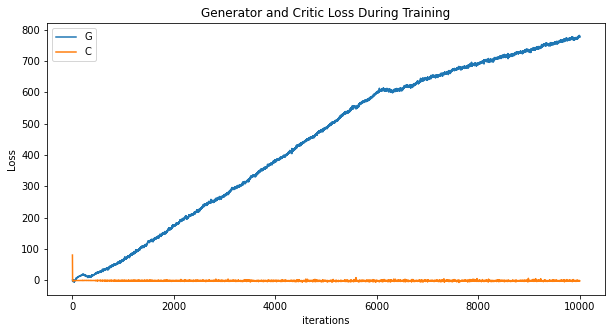

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(critic_losses,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Output From Generator Post Training

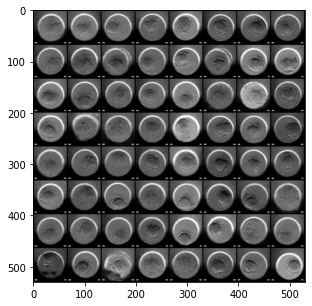

In [20]:
plt.figure(figsize=(7,5))
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)));